In [1]:
import pandas as pd
import numpy as np


from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error

from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [2]:
data_ts_1 = pd.read_csv("/Users/marcohattingh/Desktop/Research Assignment/Data/Bonds main data.csv")


In [3]:
data_ts_2 = pd.read_csv("/Users/marcohattingh/Desktop/Research Assignment/Data/Bonds main data 2.csv")

In [5]:
data_ts_1.rename(columns={data_ts_1.columns[0]:"Bloomberg Ticker"}, inplace=True)
data_ts_1.rename(columns={data_ts_1.columns[1]:"Variable"}, inplace= True)

In [6]:
data_ts_2.rename(columns={data_ts_2.columns[1]:"Variable"}, inplace = True)
data_ts_2.rename(columns={data_ts_2.columns[0]:"Bloomberg Ticker"}, inplace=True)

In [7]:
data_ts_1 = data_ts_1.iloc[:,:-1]

In [8]:
data_ts_1['Bloomberg Ticker'] = data_ts_1['Bloomberg Ticker'].ffill()
data_ts_2['Bloomberg Ticker'] = data_ts_2['Bloomberg Ticker'].ffill()

In [9]:
data_ts_1_long = pd.melt(data_ts_1, id_vars=["Bloomberg Ticker","Variable"], value_vars=data_ts_1.columns[2:], var_name="Date", value_name='Value')

In [10]:
data_ts_2_long = pd.melt(data_ts_2, id_vars=["Bloomberg Ticker", "Variable"], value_vars=data_ts_2.columns[2:], var_name="Date", value_name="Value")

In [11]:
merged_data = pd.merge(data_ts_1_long, data_ts_2_long, on=['Bloomberg Ticker', 'Variable', 'Date'], how='left', suffixes=('_main','_subset'))

In [13]:
merged_data['Value_main'].replace('#N/A Review',np.nan, inplace=True)
merged_data['Value_main'].replace('#NAME?',np.nan, inplace=True)
merged_data['Value_subset'].replace(' ',np.nan, inplace=True)

merged_data['Value_main'] = merged_data['Value_main'].astype(float)
merged_data['Value_subset'] = merged_data['Value_subset'].astype(float)


#print(merged_data.dtypes)

/var/folders/9d/d6f8nwyx00gf8_tltm7pqtyc0000gn/T/ipykernel_6874/2448527503.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_data['Value_main'].replace('#N/A Review',np.nan, inplace=True)
/var/folders/9d/d6f8nwyx00gf8_tltm7pqtyc0000gn/T/ipykernel_6874/2448527503.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are 

In [14]:
merged_data['Combined'] = merged_data['Value_main'].combine_first(merged_data['Value_subset'])

In [15]:
merged_data['Date'] = pd.to_datetime(merged_data['Date'], format = '%m/%d/%y', errors='coerce')

In [16]:
merged_data['Date_M_Y'] = merged_data['Date'].dt.to_period('M')

In [17]:
merged_data.sort_values(by=['Bloomberg Ticker','Variable', 'Date'], inplace=True)

In [18]:
merged_data.drop_duplicates(subset=['Bloomberg Ticker', 'Variable', 'Combined'], inplace=True)

In [19]:
indices_to_drop = merged_data[merged_data['Bloomberg Ticker'] == '2284'].index
print(indices_to_drop)

merged_data.drop(index=indices_to_drop, inplace = True)

Index([11996, 11994, 11993, 11995, 11992, 11991], dtype='int64')


In [20]:
pivot = merged_data.pivot_table(index=['Bloomberg Ticker', 'Date'], columns='Variable', values="Combined", aggfunc='first').reset_index()

In [21]:
pivot['Date'] = pivot['Date'].dt.to_period('M')

In [22]:
#Adding a column which will classify the security
pivot['Classification'] = 'Corporate Green Bond'

In [23]:
pivot.index = pivot['Date']

Import second time series dataset. Macroeconomic and stock market variables.

In [24]:
data_ts_3 = pd.read_csv("/Users/marcohattingh/Desktop/Research Assignment/Data/Time series second phase cleaned & merged.csv")

In [25]:
data_ts_3.head()

,Description,10/29/21,11/30/21,12/31/21,1/31/22,2/28/22,3/31/22,4/29/22,5/31/22,6/30/22,...,1/31/24,2/29/24,3/29/24,4/30/24,5/31/24,6/28/24,7/31/24,8/30/24,9/30/24,10/31/24
0,S&P500 VOLATILITY INDEX,16.26,27.19,17.22,24.83,30.15,20.56,33.40,26.19,28.71,...,14.35,13.40,13.01,15.65,12.92,12.44,16.36,15.00,16.73,23.16
1,S&P500 PX_LAST,4605.38,4567.00,4766.18,4515.55,4373.94,4530.41,4131.93,4132.15,3785.38,...,4845.65,5096.27,5254.35,5035.69,5277.51,5460.48,5522.30,5648.40,5762.48,5705.45
2,S&P500 PX_BID,4561.03,4528.64,4701.56,4459.92,4299.02,4499.97,4108.68,4094.66,3733.31,...,4814.01,5042.80,5200.84,4970.00,5224.07,5426.23,5484.77,5571.95,5700.44,5669.85
3,S&P500 PX_ASK,4677.16,4647.79,4834.94,4568.93,4419.26,4587.05,5434.72,4178.75,3819.46,...,4895.08,5160.48,5309.45,5075.58,5328.88,5513.21,5595.24,5713.68,5803.09,5764.36
4,EURO STOXX 50,4250.56,4063.06,4298.41,4174.60,3924.23,3902.52,3802.86,3789.21,3454.86,...,4648.40,4877.77,5083.42,4921.22,4983.67,4894.02,4872.94,4957.98,5000.45,4827.63


In [26]:
data_ts_3_pivot = data_ts_3.T

In [27]:
data_ts_3_pivot.head()

,0,1,2,3,4,5,6,7,8,9,...,68,69,70,71,72,73,74,75,76,77
Description,S&P500 VOLATILITY INDEX,S&P500 PX_LAST,S&P500 PX_BID,S&P500 PX_ASK,EURO STOXX 50,STOXX EUROPE 600,EURO STOXX 50 VOLATILITY,EUROPEAN RENEWABLE ENERGY INDEX,US IMPLIED YIELD VOLATILITY INDEX,GOLD IN EUR PX_LAST,...,EUROZONE 7-YEAR BOND YTM_ASK,EUROZONE 5-YEAR BOND YTM_BID,EUROZONE 5-YEAR BOND YTM_ASK,EUROZONE 3-YEAR BOND YTM_BID,EUROZONE 3-YEAR BOND YTM_ASK,EUROZONE 2-YEAR BOND YTM_BID,EUROZONE 2-YEAR BOND YTM_ASK,NASDAQ CLEAN EDGE GREEN ENERGY,MSCI EUROPE SELECT GREEN 50 5% DECREMENT NET I...,BLOOMBERG ECONOMIC SURPRISE INDEX - EUROZONE
10/29/21,16.26,4605.38,4561.03,4677.16,4250.56,475.51,17.6164,2458.32,75.45,1542.54,...,-0.264,-0.39,-0.394,-0.542,-0.553,-0.585,-0.597,1012.5,1864.62,105.61
11/30/21,27.19,4567.0,4528.64,4647.79,4063.06,462.96,30.0679,2294.14,84.04,1565.07,...,-0.519,-0.618,-0.627,-0.744,-0.759,-0.737,-0.756,1008.21,1808.27,100.34
12/31/21,17.22,4766.18,4701.56,4834.94,4298.41,487.8,19.2677,2216.63,77.1,1608.82,...,-0.366,-0.453,-0.469,-0.641,-0.67,-0.62,-0.651,889.43,1880.8,106.93
1/31/22,24.83,4515.55,4459.92,4568.93,4174.6,468.88,27.0084,1970.35,85.14,1599.48,...,-0.179,-0.22,-0.234,-0.426,-0.436,-0.528,-0.544,748.43,1734.29,100.96


In [28]:
data_ts_3_pivot.columns = data_ts_3_pivot.iloc[0]

In [29]:
data_ts_3_pivot = data_ts_3_pivot.drop(index='Description')

In [30]:
data_ts_3_pivot.index = pd.to_datetime(data_ts_3_pivot.index, format='%m/%d/%y')
data_ts_3_pivot.index = data_ts_3_pivot.index.to_period('M')

In [31]:
data_ts_3_pivot.index.name = 'Date'

Merging the two datasets


In [32]:
pivot = pivot.drop(columns='Date')

In [33]:
final_1 = pd.merge(pivot, data_ts_3_pivot, how='outer', on='Date')

In [34]:
final_1.rename(columns={final_1.columns[0]:'Ticker'}, inplace=True)

Static data import and merge

In [35]:
static_1 = pd.read_csv('/Users/marcohattingh/Desktop/Research Assignment/Data/Bonds Static data 2.csv')

In [36]:
static_1.rename(columns={static_1.columns[0]:'Ticker'}, inplace=True)

In [37]:
static_2 = pd.read_csv('/Users/marcohattingh/Desktop/Research Assignment/Data/Bonds Static data 3.csv')

In [38]:
static_2.rename(columns={static_2.columns[7]:'Ticker'}, inplace=True)

In [39]:
static_3 = pd.read_csv('/Users/marcohattingh/Desktop/Research Assignment/Data/Bonds Static data 4.csv')

In [40]:
static_3.rename(columns={static_3.columns[11]:'Ticker'}, inplace=True)

In [41]:
static_4 = pd.read_csv('/Users/marcohattingh/Desktop/Research Assignment/Data/Bonds Static data 5_use of proceeds.csv')

In [42]:
static_4.rename(columns={static_4.columns[1]:'Ticker'}, inplace= True)

In [43]:
final_1['Date'] = final_1.index

In [44]:
final_2 = pd.merge(final_1, static_1,  how='outer', on='Ticker')

In [45]:
final_2 = pd.merge(final_2, static_2,  how='outer', on='Ticker')

In [46]:
final_2 = pd.merge(final_2, static_3,  how='outer', on='Ticker')

In [47]:
final_2 = pd.merge(final_2, static_4,  how='outer', on='Ticker')

In [48]:
final_2.replace('#N/A Field Not Applicable', np.nan, inplace=True)

/var/folders/9d/d6f8nwyx00gf8_tltm7pqtyc0000gn/T/ipykernel_6874/1454516632.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  final_2.replace('#N/A Field Not Applicable', np.nan, inplace=True)


In [49]:
final_2.index = final_2['Date']

In [50]:
final_2 = final_2.drop(columns='Date')

Analysing of dataset

In [51]:
pd.set_option('display.max_rows', None)
#print(final_2.dtypes)

In [52]:
#print(type(final_2))

In [53]:
pd.set_option('display.max_rows', None)
#print(final_2.dtypes)

In [54]:

def convert_columns(final_2, max_unique_ratio=0.1, max_unique_count=20):
    for col in final_2.columns:
        print(f"Processing column: {col}")

        # Step 1: Handle numeric conversion more robustly
        try:
            # First try converting to numeric, preserving original type if possible
            numeric_series = pd.to_numeric(final_2[col], errors='coerce')
            
            # Check if conversion was meaningful
            if not numeric_series.isna().all():
                # Prefer integer if no decimal loss
                if np.allclose(numeric_series, numeric_series.astype(int), rtol=1e-5, atol=1e-8):
                    final_2[col] = numeric_series.astype(int)
                    print(f"Column {col} converted to integer")
                else:
                    final_2[col] = numeric_series.astype(float)
                    print(f"Column {col} converted to float")
                continue
        except Exception as e:
            print(f"Detailed error converting column {col} to numeric: {e}")

        # Step 2: Handle categorical columns more carefully
        if final_2[col].dtype == 'object':
            unique_count = final_2[col].nunique()
            total_count = len(final_2[col])
            
            # Multiple checks for categorical
            if (unique_count / total_count < max_unique_ratio) or \
               (0 < unique_count <= max_unique_count):
                final_2[col] = final_2[col].astype('category')
                print(f"Column {col} converted to category")

    return final_2

In [ ]:
final_2 = convert_columns(final_2)


Processing column: Ticker
Column Ticker converted to category
Processing column: PX_ASK
Detailed error converting column PX_ASK to numeric: Cannot convert non-finite values (NA or inf) to integer
Processing column: PX_BID
Detailed error converting column PX_BID to numeric: Cannot convert non-finite values (NA or inf) to integer
Processing column: YLD_YTM_ASK
Detailed error converting column YLD_YTM_ASK to numeric: Cannot convert non-finite values (NA or inf) to integer
Processing column: YLD_YTM_BID
Detailed error converting column YLD_YTM_BID to numeric: Cannot convert non-finite values (NA or inf) to integer
Processing column: Classification
Column Classification converted to category
Processing column: S&P500 VOLATILITY INDEX
Detailed error converting column S&P500 VOLATILITY INDEX to numeric: Cannot convert non-finite values (NA or inf) to integer
Processing column: S&P500 PX_LAST
Detailed error converting column S&P500 PX_LAST to numeric: Cannot convert non-finite values (NA or in

In [56]:
final_2['Issue Price'] = final_2['Issue Price'].astype(float)
final_2['Issue Date'] = pd.to_datetime(final_2['Issue Date'],format='%m/%d/%Y', errors='coerce')

In [57]:
final_2 = final_2.copy()

final_2['Issue Price'] = final_2['Issue Price'].astype(float)
final_2['Issue Date'] = pd.to_datetime(final_2['Issue Date'], format='%m/%d/%Y', errors='coerce')

In [58]:
#print(final_2.dtypes)

In [59]:
final_2.reset_index(inplace=True)
final_3 = final_2.dropna(subset=['Date','YLD_YTM_ASK'], how='all', inplace=False)


In [60]:
#drop entries where all four variables are missing
final_3 = final_3.dropna(subset=['YLD_YTM_ASK','YLD_YTM_BID','PX_ASK','PX_BID'], how='all')

In [61]:
# Count rows where exactly 4 specified columns have NaN values
count = final_3[['YLD_YTM_ASK', 'YLD_YTM_BID', 'PX_ASK', 'PX_BID']].isna().sum(axis=1).eq(4).sum()
print(count)

0


In [64]:
#Extraction of date components
final_3['year'] = final_3['Date'].dt.year
final_3['month'] = final_3['Date'].dt.month
final_3['quarter'] = final_3['Date'].dt.quarter


In [65]:
# Accounting for cyclicality of months (allowing proximity of month 12 to month 1 to be observed)
final_3['month_sin'] = np.sin(2 * np.pi * final_3['month'] / 12)
final_3['month_cos'] = np.cos(2 * np.pi * final_3['month'] / 12)

Encoding of string variables


In [66]:
final_2.to_csv('/Users/marcohattingh/Desktop/Research Assignment/Data/final_2.csv', index=True)

In [67]:
cpn_freq = pd.read_csv("/Users/marcohattingh/Desktop/Research Assignment/Data/ISIN_CPN_FREQ_BBG.csv")

In [68]:
#print(cpn_freq.dtypes)
#print(final_2.dtypes)

#cpn_freq['Ticker'] = cpn_freq["Ticker"].astype('category')

In [69]:
#print(final_2['Ticker'].cat.categories)
#print(cpn_freq['Ticker'].cat.categories)

In [70]:
final_merge = pd.merge(final_2, cpn_freq, on=["Ticker"])

In [71]:
# An easier way to drop the missing value rows
final_merge = final_merge.dropna(subset=['Ticker', 'Date'])

In [72]:
# Bit more complex way to drop the missing value rows
to_drop = final_merge[(final_merge['Ticker']==' ') | (final_merge['Date']==' ')]
final_merge =final_merge.drop(to_drop.index)

In [74]:
#Convert dates into constant format
final_merge['Maturity'] = pd.to_datetime(final_merge['Maturity'])
#final_merge['Maturity'] = pd.to_datetime(final_merge['Maturity'], format = '%m/%d/%Y').dt.strftime('%d/%m/%Y')
#final_merge['Maturity'] = pd.to_datetime(final_merge['Maturity'], format='%d/%m/%Y')
final_merge['Date'] = final_merge['Date'].dt.to_timestamp('M')

In [75]:
# Calculating mid price 
final_merge['Mid_PX'] = (((final_merge['PX_ASK']+final_merge['PX_BID'])/2))


In [76]:
#back calculating the coupon dates
coupon_1 = ['ISIN','Ticker','Maturity','Issue Date','Cpn','Date','CPN_FREQ','Par Amount']
coupon_dates = final_merge[coupon_1]

In [77]:
coupon_dates['Accrual period'] = (360/(coupon_dates['CPN_FREQ']))
coupon_dates['period_coupon'] =  ((coupon_dates['Cpn'])/coupon_dates['CPN_FREQ'])
coupon_dates['period_months'] = 12/ coupon_dates['CPN_FREQ']
#((coupon_dates['Cpn'])/(coupon_dates['CPN_FREQ']))*100

/var/folders/9d/d6f8nwyx00gf8_tltm7pqtyc0000gn/T/ipykernel_6874/849711941.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coupon_dates['Accrual period'] = (360/(coupon_dates['CPN_FREQ']))
/var/folders/9d/d6f8nwyx00gf8_tltm7pqtyc0000gn/T/ipykernel_6874/849711941.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coupon_dates['period_coupon'] =  ((coupon_dates['Cpn'])/coupon_dates['CPN_FREQ'])
/var/folders/9d/d6f8nwyx00gf8_tltm7pqtyc0000gn/T/ipykernel_6874/849711941.py:3: SettingWithCopyWarning: 
A value

In [78]:
df = coupon_dates.copy()

from pandas.api.types import is_period_dtype, is_datetime64_any_dtype

# 1) Core dtypes
df['Maturity']   = pd.to_datetime(df['Maturity'], errors='coerce')
df['Issue Date'] = pd.to_datetime(df['Issue Date'], errors='coerce')
df['CPN_FREQ']   = pd.to_numeric(df['CPN_FREQ'], errors='coerce').astype('Int64')
df['Cpn']        = pd.to_numeric(df['Cpn'], errors='coerce')

# 2) Normalize Date to month-end Timestamp without ever passing Period to to_datetime
if is_period_dtype(df['Date']):
    # Already Period[M] -> convert to month-end timestamps
    df['Date'] = df['Date'].dt.to_timestamp('M')
elif is_datetime64_any_dtype(df['Date']):
    # Already datetime -> push to month-end
    df['Date'] = df['Date'] + pd.offsets.MonthEnd(0)
else:
    # Likely strings like '2021-10' -> parse, then month-end
    # (If your strings are strictly YYYY-MM, the format speeds parsing)
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce', format='%Y-%m', exact=False)
    df['Date'] = df['Date'] + pd.offsets.MonthEnd(0)

/var/folders/9d/d6f8nwyx00gf8_tltm7pqtyc0000gn/T/ipykernel_6874/2168478596.py:12: DeprecationWarning: is_period_dtype is deprecated and will be removed in a future version. Use `isinstance(dtype, pd.PeriodDtype)` instead
  if is_period_dtype(df['Date']):


In [79]:
# building last/next coupon dates per row
def last_next_coupon_from_maturity(maturity, freq, valuation_date):
    """
    Build schedule backward from maturity stepping 12/f months.
    Return (last_coupon_date, next_coupon_date) around valuation_date.
    """
    if pd.isna(freq) or freq not in (1, 2, 4):
        return (pd.NaT, pd.NaT)

    period_months = int(12 // int(freq))
    schedule = []
    d = maturity
    cutoff = valuation_date - pd.DateOffset(years=30)  # far enough back

    while d > cutoff:
        schedule.append(d)
        d = d - pd.DateOffset(months=period_months)

    schedule.sort()
    if not schedule:
        return (pd.NaT, pd.NaT)

    # last <= valuation_date
    last_cpn = None
    for dt in schedule:
        if dt <= valuation_date:
            last_cpn = dt
        else:
            break

    # next > valuation_date
    next_cpn = next((dt for dt in schedule if dt > valuation_date), pd.NaT)
    if last_cpn is None:
        # valuation before first generated coupon -> treat first as next, no last
        first = schedule[0]
        return (pd.NaT, first)

    return (last_cpn, next_cpn)

In [80]:
#applying the previously generated code
out = df.apply(
    lambda r: pd.Series(
        last_next_coupon_from_maturity(
            r['Maturity'],
            int(r['CPN_FREQ']) if pd.notna(r['CPN_FREQ']) else None,
            r['Date']
        ),
        index=['LastCouponDate', 'NextCouponDate']
    ),
    axis=1
)

df = pd.concat([df, out], axis=1)

In [81]:
#Accrual fraction
days_since_last = (df['Date'] - df['LastCouponDate']).dt.days
days_in_period  = (df['NextCouponDate'] - df['LastCouponDate']).dt.days
df['accrual_frac_act'] = (days_since_last / days_in_period).clip(lower=0, upper=1)

In [82]:
#Approximation of accrual fraction based on 30/360 timeframe
df['accrual_frac_30360'] = (
    (df['Date'] - df['LastCouponDate']).dt.days / (360 / df['CPN_FREQ'])
).clip(lower=0)

In [83]:
# What exactly is happening here??
df['accrual_frac'] = df['accrual_frac_act']

In [84]:
#calculating accrued interest
df['AccruedInterest'] = df['period_coupon'] * df['accrual_frac']
final_merge['period_coupon'] = df['period_coupon']
final_merge['AccruedInterest'] = df['AccruedInterest']

In [85]:
#merging newly calculated data
# keys to join on (adjust to your ID columns)
keys = ['ISIN', 'Ticker', 'Date']  # e.g., ['ISIN', 'Date']

# pick only columns in df that are not already in final_merge (exclude keys)
new_cols = [c for c in df.columns if c not in final_merge.columns and c not in keys]

# if there are no new columns, nothing to do
if new_cols:
    df_sub = df[keys + new_cols].drop_duplicates(subset=keys)
    final_merge = final_merge.merge(df_sub, on=keys, how='left')


In [86]:
#### Debugging last coupon
df['Maturity'] = pd.to_datetime(df['Maturity'], errors='coerce')
# if your Date is 'YYYY-MM', convert to month-end Timestamps
if not pd.api.types.is_datetime64_any_dtype(df['Date']):
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce', format='%Y-%m')
df['Date'] = df['Date'] + pd.offsets.MonthEnd(0)

df['CPN_FREQ'] = pd.to_numeric(df['CPN_FREQ'], errors='coerce').astype('Int64')
df['Cpn']      = pd.to_numeric(df['Cpn'], errors='coerce')

In [87]:
def build_schedule_from_maturity(maturity: pd.Timestamp, freq: int, back_years: int = 40) -> pd.DatetimeIndex:
    if pd.isna(maturity) or pd.isna(freq) or freq not in (1, 2, 4):
        return pd.DatetimeIndex([])
    months = int(12 // int(freq))
    dates = []
    d = maturity
    cutoff = maturity - pd.DateOffset(years=back_years)
    while d >= cutoff:
        dates.append(d)
        d = d - pd.DateOffset(months=months)
    return pd.DatetimeIndex(sorted(dates))

In [88]:
schedules = {}
for isin, g in df.groupby('ISIN', sort=False):
    m = g['Maturity'].iloc[0]
    f = g['CPN_FREQ'].iloc[0]
    schedules[isin] = build_schedule_from_maturity(m, int(f) if pd.notna(f) else None)

In [89]:
def last_next_from_schedule(schedule: pd.DatetimeIndex, valuation: pd.Timestamp):
    if len(schedule) == 0 or pd.isna(valuation):
        return pd.NaT, pd.NaT
    # insertion point *after* valuation
    i = schedule.searchsorted(valuation, side='right')
    last_d = schedule[i-1] if i > 0 else pd.NaT
    next_d = schedule[i]   if i < len(schedule) else pd.NaT
    return last_d, next_d

In [90]:
out = df.apply(
    lambda r: pd.Series(
        last_next_from_schedule(schedules.get(r['ISIN'], pd.DatetimeIndex([])), r['Date']),
        index=['LastCouponDate','NextCouponDate']
    ),
    axis=1
)
df = pd.concat([df, out], axis=1)

In [91]:
# pick one ISIN and inspect
check = df.loc[df['ISIN'].eq(df['ISIN'].iloc[100]), ['Date','LastCouponDate','NextCouponDate']].sort_values('Date').head(12)
print(check)

         Date LastCouponDate LastCouponDate NextCouponDate NextCouponDate
75 2021-10-31     2021-07-17     2021-07-17     2022-01-17     2022-01-17
76 2021-11-30     2021-07-17     2021-07-17     2022-01-17     2022-01-17
77 2021-12-31     2021-07-17     2021-07-17     2022-01-17     2022-01-17
78 2022-01-31     2022-01-17     2022-01-17     2022-07-17     2022-07-17
79 2022-02-28     2022-01-17     2022-01-17     2022-07-17     2022-07-17
80 2022-03-31     2022-01-17     2022-01-17     2022-07-17     2022-07-17
81 2022-04-30     2022-01-17     2022-01-17     2022-07-17     2022-07-17
82 2022-05-31     2022-01-17     2022-01-17     2022-07-17     2022-07-17
83 2022-06-30     2022-01-17     2022-01-17     2022-07-17     2022-07-17
84 2022-07-31     2022-07-17     2022-07-17     2023-01-17     2023-01-17
85 2022-08-31     2022-07-17     2022-07-17     2023-01-17     2023-01-17
86 2022-09-30     2022-07-17     2022-07-17     2023-01-17     2023-01-17


In [92]:
df = df.iloc[:,:-2]

In [94]:
#calculating dirty_mid
final_merge['dirty_mid'] = (final_merge['Mid_PX']) + (final_merge['AccruedInterest'])

In [95]:
#Debugging last coupon & next coupon attempt 2
# 1) See what columns got suffixed
[c for c in final_merge.columns if c.endswith(('_x','_y'))]

# 2) Check dtypes before/after merge
df[['ISIN','Date','Maturity','CPN_FREQ']].dtypes
final_merge[['ISIN','Date','Maturity','CPN_FREQ']].dtypes

# 3) Did you merge on the right keys?
# If your last/next were computed per (ISIN, Date), you MUST merge on BOTH.

ISIN                object
Date        datetime64[ns]
Maturity    datetime64[ns]
CPN_FREQ             int64
dtype: object

In [96]:
#Evaluation
view1 = ['Date','Issue Date', 'Maturity', 'LastCouponDate','NextCouponDate', 'PX_ASK', 'PX_BID', 'Mid_PX','dirty_mid']
view2 = final_merge[view1]

In [97]:
final_merge.to_csv('/Users/marcohattingh/Desktop/Research Assignment/Data/final_merge.csv', index=False)

In [98]:
#Calculation of returns
final_merge = final_merge.sort_values(['Ticker','Date'])
final_merge['monthly_return_nom'] = final_merge.groupby('Ticker')['dirty_mid'].diff()
final_merge['monthly_return_pct'] = final_merge.groupby('Ticker')['dirty_mid'].pct_change()

/var/folders/9d/d6f8nwyx00gf8_tltm7pqtyc0000gn/T/ipykernel_6874/1940906622.py:4: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  final_merge['monthly_return_pct'] = final_merge.groupby('Ticker')['dirty_mid'].pct_change()


In [99]:
duplicates = final_merge.duplicated(subset=['Ticker','Date']).sum()
print("Duplicate (Ticker,Date) rows:", duplicates)

Duplicate (Ticker,Date) rows: 0


In [100]:
#Activate if interested in quarterly return
#df_encoded['quarterly_return'] = df_encoded.groupby('Ticker')['dirty_mid'].pct_change(periods=3)

In [101]:
'''coupon_dates['Maturity'] = pd.to_datetime(coupon_dates['Maturity'])
coupon_dates['Date'] = pd.to_datetime(coupon_dates['Date']).dt.to_period('M').dt.to_timestamp('M')
coupon_dates['CPN_FREQ'] = pd.to_numeric(coupon_dates['CPN_FREQ'], errors='coerce').astype('Int64')'''

"coupon_dates['Maturity'] = pd.to_datetime(coupon_dates['Maturity'])\ncoupon_dates['Date'] = pd.to_datetime(coupon_dates['Date']).dt.to_period('M').dt.to_timestamp('M')\ncoupon_dates['CPN_FREQ'] = pd.to_numeric(coupon_dates['CPN_FREQ'], errors='coerce').astype('Int64')"

In [412]:
#creating a copy of final merge
maindf = final_merge.copy()


In [413]:
#S&P Variable returns calculation
sp = maindf[['Date','S&P500 PX_LAST']]
sp = sp.drop_duplicates('Date')
sp['S&P500 monthly_return'] = sp['S&P500 PX_LAST'].pct_change()
sp['S&P500 ret_lag_1'] = sp['S&P500 monthly_return'].shift(1)
sp['S&P500 ret_lag_2'] = sp['S&P500 monthly_return'].shift(2)

maindf = pd.merge(sp[['Date','S&P500 monthly_return','S&P500 ret_lag_1','S&P500 ret_lag_2']], maindf, on='Date',how='left')

In [414]:
#Stoxx 50
sx50 = maindf[['Date','EURO STOXX 50']]
sx50 = sx50.drop_duplicates('Date')
sx50['STOXX 50 monthly_return'] = sx50['EURO STOXX 50'].pct_change()
sx50['STOXX 50 ret_lag1'] = sx50['STOXX 50 monthly_return'].shift(1)
sx50['STOXX 50 ret_lag2'] = sx50['STOXX 50 monthly_return'].shift(2)

maindf = pd.merge(sx50[['Date','STOXX 50 monthly_return','STOXX 50 ret_lag1','STOXX 50 ret_lag2']], maindf, on='Date',how='left' )

In [415]:
#STOXX 600
sx600 = maindf[['Date','STOXX EUROPE 600']]
sx600 = sx600.drop_duplicates('Date')
sx600['STOXX 600 monthly_return'] = sx600['STOXX EUROPE 600'].pct_change()
sx600['STOXX 600 ret_lag1'] = sx600['STOXX EUROPE 600'].shift(1)

maindf = pd.merge(sx600[['Date','STOXX 600 monthly_return','STOXX 600 ret_lag1']],maindf, on='Date', how = 'left')

In [416]:
#Gold 
gold = maindf[['Date','GOLD IN EUR PX_LAST']]
gold = gold.drop_duplicates('Date')
gold['gold monthly_return'] = gold['GOLD IN EUR PX_LAST'].pct_change()
gold['gold ret_lag1'] = gold['gold monthly_return'].shift(1)

maindf = pd.merge(gold[['Date','gold monthly_return','gold ret_lag1']], maindf, on='Date',how='left')


In [417]:
#WTI
wti = maindf[['Date','WTI PX_LAST']]
wti = wti.drop_duplicates('Date')
wti['WTI monthly_return'] = wti['WTI PX_LAST'].pct_change()
wti['WTI ret_lag1'] = wti['WTI monthly_return'].shift(1)

maindf = pd.merge(wti[['Date','WTI monthly_return', 'WTI ret_lag1']], maindf, on='Date', how='left')

In [418]:
#BRENT
brent = maindf[['Date','BRENT CRUDE PX_LAST']]
brent = brent.drop_duplicates('Date')
brent['BRENT monthly_return'] = brent['BRENT CRUDE PX_LAST'].pct_change()
brent['BRENT ret_lag1'] = brent['BRENT monthly_return'].shift(1)

maindf = pd.merge(brent[['Date','BRENT monthly_return', 'BRENT ret_lag1']], maindf, on='Date',how='left')



In [419]:
#VIX 
vix = maindf[['Date','S&P500 VOLATILITY INDEX']]
vix = vix.drop_duplicates('Date')
vix['S&P500 VIX_lag_1_ret'] = vix['S&P500 VOLATILITY INDEX'].pct_change().shift(1)

maindf = pd.merge(vix[['Date', 'S&P500 VIX_lag_1_ret']], maindf, on='Date',how='left')

In [420]:
#STOXX VIX
svix = maindf[['Date','EURO STOXX 50 VOLATILITY']]
svix = svix.drop_duplicates('Date')
svix['STOXX_VIX_RET_lag1'] = svix['EURO STOXX 50 VOLATILITY'].pct_change().shift(1)
svix['STOXX50 VIX_lag_1'] = svix['EURO STOXX 50 VOLATILITY'].shift(1)

maindf = pd.merge(svix[['Date', 'STOXX50 VIX_lag_1','STOXX_VIX_RET_lag1']], maindf, on='Date',how='left')

In [421]:
#ECB Policy rates
ecb_rate = maindf[['Date','ECB DEPOSIT FACILITY RATE']]
ecb_rate = ecb_rate.drop_duplicates('Date')
ecb_rate['ECB_rate_change_lag'] = ecb_rate['ECB DEPOSIT FACILITY RATE'].diff().shift(1)
ecb_rate['ecb_rate_lag1'] = ecb_rate['ECB DEPOSIT FACILITY RATE'].shift(1)
ecb_rate['ecb_rate_lag2'] = ecb_rate['ECB DEPOSIT FACILITY RATE'].shift(2)

maindf = pd.merge(ecb_rate[['Date','ECB_rate_change_lag','ecb_rate_lag1','ecb_rate_lag2']], maindf, on='Date', how='left')


In [422]:
#FED Policy rates
fed_rate = maindf[['Date','US EFFECTIVE FEDERAL FUNDS RATE']]
fed_rate = fed_rate.drop_duplicates('Date')
fed_rate['FED_rate_change_lag'] = fed_rate['US EFFECTIVE FEDERAL FUNDS RATE'].diff().shift(1)
fed_rate['FED_rate_lag1'] = fed_rate['US EFFECTIVE FEDERAL FUNDS RATE'].shift(1)
fed_rate['FED_rate_lag2'] = fed_rate['US EFFECTIVE FEDERAL FUNDS RATE'].shift(2)

maindf = pd.merge(fed_rate[['Date','FED_rate_change_lag','FED_rate_lag1','FED_rate_lag2']], maindf, on = 'Date', how = 'left')

In [423]:
#Calculating mid duration, convexity and the spread
maindf['duration_mid'] = (maindf['Mod Dur (Bid)'] + maindf['Mod Dur (Ask)']) / 2
maindf['convexity_mid'] = (maindf['Bid Convexity'] + maindf['Ask Convexity']) / 2
maindf['duration_mid_lag1'] = maindf['duration_mid'].shift(1)
maindf['convexity_mid_lag1'] = maindf['convexity_mid'].shift(1)


maindf['duration_spread'] = maindf['Mod Dur (Ask)'] - maindf['Mod Dur (Bid)']
maindf['convexity_spread'] = maindf['Ask Convexity'] - maindf['Bid Convexity']

In [424]:
#Years to maturity
maindf['years_to_mty'] = maindf['Maturity'] - maindf['Date']
maindf['years_to_mty'] = (maindf['years_to_mty'].dt.days.astype(float))

In [425]:
#Log amount issued
maindf['Amount issued'] = maindf['Amount issued'].astype(float)
maindf['log_amount_issued'] = np.log(maindf['Amount issued'])
print(maindf['log_amount_issued'].dtypes)

float64


In [116]:
#bid ask spread
maindf['bid_ask_spread_bps'] =  1e4 * (maindf['PX_ASK'] - maindf['PX_BID'])/maindf['Mid_PX']

In [426]:
#ESG INDEX S&P
esg500 = maindf[['Date','S&P 500 ESG INDEX (USD)']]
esg500 = esg500.drop_duplicates('Date')
#esg500.plot(x='Date',y='S&P 500 ESG INDEX (USD)')
esg500['ESG Index monthly_return'] = esg500['S&P 500 ESG INDEX (USD)'].pct_change()
esg500['ESG500_lag1'] = esg500['ESG Index monthly_return'].shift(1)


maindf = pd.merge(esg500[['Date','ESG Index monthly_return','ESG500_lag1']], maindf, on='Date', how='left')

In [427]:
#STOXX EUROPE 600 ENERGY INDEX
y ='STOXX EUROPE 600 ENERGY INDEX'
x = maindf[['Date',y]]

x = x.drop_duplicates('Date')
#esg500.plot(x='Date',y='S&P 500 ESG INDEX (USD)')
x['STOXX_600_energy_index_pct_change'] = x[y].pct_change()
x['STOXX_600_energy_index ret_lag1'] = x['STOXX_600_energy_index_pct_change'].shift(1)


maindf = pd.merge(x[['Date','STOXX_600_energy_index_pct_change','STOXX_600_energy_index ret_lag1']], maindf, on='Date', how='left')

In [428]:
#NASDAQ CLEAN EDGE GREEN ENERGY
y ='NASDAQ CLEAN EDGE GREEN ENERGY'
x = maindf[['Date',y]]

x = x.drop_duplicates('Date')
#esg500.plot(x='Date',y='S&P 500 ESG INDEX (USD)')
x['NASDAQ CLEAN EDGE GREEN ENERGY_pct_change'] = x[y].pct_change()
x['NASDAQ CLEAN EDGE GREEN ENERGY ret_lag1'] = x['NASDAQ CLEAN EDGE GREEN ENERGY_pct_change'].shift(1)


maindf = pd.merge(x[['Date','NASDAQ CLEAN EDGE GREEN ENERGY_pct_change','NASDAQ CLEAN EDGE GREEN ENERGY ret_lag1']], maindf, on='Date', how='left')

In [429]:
#MSCI EUROPE SELECT GREEN 50 5% DECREMENT NET INDEX (EUR)
y ='MSCI EUROPE SELECT GREEN 50 5% DECREMENT NET INDEX (EUR)'
x = maindf[['Date',y]]

x = x.drop_duplicates('Date')
#esg500.plot(x='Date',y='S&P 500 ESG INDEX (USD)')
x['MSCI Europe_select_green_pct_change'] = x[y].pct_change()
x['MSCI Europe_select_green ret_lag1'] = x['MSCI Europe_select_green_pct_change'].shift(1)


maindf = pd.merge(x[['Date','MSCI Europe_select_green_pct_change','MSCI Europe_select_green ret_lag1']], maindf, on='Date', how='left')

In [430]:
#BLOOMBERG ECONOMIC SURPRISE INDEX - EUROZONE
y ='BLOOMBERG ECONOMIC SURPRISE INDEX - EUROZONE'
x = maindf[['Date',y]]

x = x.drop_duplicates('Date')
#esg500.plot(x='Date',y='S&P 500 ESG INDEX (USD)')
x['Bloomberg_economic_surprise_index_difference'] = x[y].diff().abs()
x['Bloomberg_economic_surprise_index_difference_ret_lag1'] = x['Bloomberg_economic_surprise_index_difference'].shift(1)


maindf = pd.merge(x[['Date','Bloomberg_economic_surprise_index_difference','Bloomberg_economic_surprise_index_difference_ret_lag1']], maindf, on='Date', how='left')

In [ ]:
#q1  = maindf.groupby('Date')['bid_ask_spread_bps'].transform(lambda s: s.quantile(0.01))
#q99 = maindf.groupby('Date')['bid_ask_spread_bps'].transform(lambda s: s.quantile(0.99))
#maindf['bid_ask_spread_bps'] = maindf['bid_ask_spread_bps'].clip(q1, q99)


In [ ]:
# c) convert to cross-sectional rank/decile (removes bond-specific levels)
#maindf['rel_spread_rank'] = maindf.groupby('Date')['bid_ask_spread_bps']\
                          #.rank(pct=True, method='average')  # 0..1 within each date

# d) LAG it (avoid leakage)
#maindf['rel_spread_rank_l1'] = maindf.groupby('Ticker')['rel_spread_rank'].shift(1)

In [178]:
df_encoded.to_csv("/Users/marcohattingh/Desktop/Research Assignment/Data/df_encoded.csv")

Encoding categorical variables

In [ ]:
cat_cols = ['Country','Currency','BICS Level 2']
df_encoded = maindf.copy()

Visual analysis of distributions and lag correlations

Building the first model

In [ ]:
#month_const = {c: (df_encoded.groupby('Date')[c].nunique().max()==1) for c in X_train.columns}
# True ⇒ time-factor (same across bonds in month). False ⇒ cross-sectional feature.
#print(month_const)

{'S&P500 VIX_lag_1_ret': True, 'STOXX_VIX_RET_lag1': True}


In [487]:
#Debugging NaNs
maindf['row_in_bond'] = maindf.groupby('ISIN').cumcount()
# 1 row must be dropped per bond because of pct_change(1)
maindf = maindf[maindf['row_in_bond'] >= 1].copy()

In [467]:

# Dummy columns start with these prefixes after get_dummies:D
dummy_prefixes = ['Country_'] #, 'Currency_', 'BICS Level 2'

# Extract all dummy columns automatically:
dummy_cols = [c for c in df_encoded.columns if c.startswith(tuple(dummy_prefixes))]

#numeric_cols = [,] # 
#feature_cols = numeric_cols 
#+  dummy_cols


In [463]:


# Relative spread in basis points
maindf['bid_ask_spread_bps'] = (maindf['PX_ASK'] - maindf['PX_BID']) / maindf['Mid_PX'] * 10_000

# If you want change from previous period (per bond):
maindf['spread_bps_lag1'] = maindf.groupby('Ticker')['bid_ask_spread_bps'].shift(1)
maindf['spread_bps_pct_change'] = maindf.groupby('Ticker')['bid_ask_spread_bps'].pct_change()
maindf['spread_bps_diff'] = maindf.groupby('Ticker')['bid_ask_spread_bps'].diff()

/var/folders/9d/d6f8nwyx00gf8_tltm7pqtyc0000gn/T/ipykernel_6874/3329385055.py:6: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  maindf['spread_bps_pct_change'] = maindf.groupby('Ticker')['bid_ask_spread_bps'].pct_change()


<Axes: >

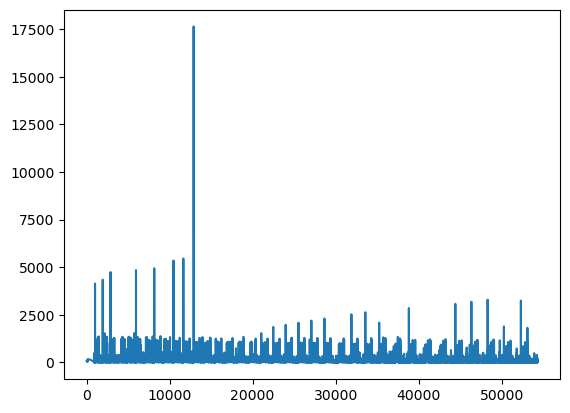

In [464]:
maindf['bid_ask_spread_bps'] = maindf['bid_ask_spread_bps'].clip(lower=0)
maindf['bid_ask_spread_bps'].plot()


In [465]:
maindf['spread_bps_diff'] = maindf.groupby('Ticker')['bid_ask_spread_bps'].diff()

In [468]:
df_encoded['spread_bps_pct_change'] = df_encoded['spread_bps_pct_change'].replace([np.inf, -np.inf], np.nan)

In [488]:
#defining X and y
y = df_encoded['bid_ask_spread_bps']
X = df_encoded[set23]

In [489]:
# encode categoricals beforehand -> df_encoded
#y = df_encoded['monthly_return'] -- NOT NEEDED EARLIER CODE ALREADY DEFINES Y

# choose/assemble your feature columns
#X = df_encoded.drop(columns=['monthly_return','Date']) -- NOT NEEDED AS EARLIER CODE ALREADY DEFINES X

# final NaN filter (y can’t have NaNs; X NaNs will be imputed in pipelines,
# but it’s cleaner to drop rows with y NaN and keep X rows aligned)
mask = y.notna()
X, y = X[mask], y[mask]

In [490]:
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_squared_error


def evaluate(y_true, y_pred, name="model"):
    r2   = r2_score(y_true, y_pred)
    mae  = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f"{name:20s} | R²={r2:6.3f}  MAE={mae:8.5f}  RMSE={rmse:8.5f}")

In [491]:
cutoff = df_encoded.loc[mask, 'Date'].quantile(0.8)
train = df_encoded.loc[mask, 'Date'] <= cutoff
test  = df_encoded.loc[mask, 'Date'] >  cutoff

X_train, y_train = X[train], y[train]
X_test,  y_test  = X[test],  y[test]

# Baseline mean (no NaNs now)
train_mean = np.nanmean(y_train)
y_pred_mean = np.full(y_test.shape, train_mean)
evaluate(y_test, y_pred_mean, name="Baseline: train-mean")

Baseline: train-mean | R²=-0.021  MAE=50.16592  RMSE=112.37327


In [492]:
# Predict the train-set mean return for every test point (very hard baseline to beat in bonds)
y_pred_mean = np.full_like(y_test, fill_value=np.nan, dtype=float)
y_pred_mean[:] = np.nanmean(y_train)
evaluate(y_test, y_pred_mean, name="Baseline: train-mean")

Baseline: train-mean | R²=-0.021  MAE=50.16592  RMSE=112.37327


In [170]:
# =========================================
# Clean two-step pipeline (stable version)
# =========================================
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# --------- helpers ----------
def evaluate_true_pred(y_true, y_pred, name="Model"):
    y_true = pd.Series(y_true, dtype=float)
    y_pred = pd.Series(y_pred, dtype=float)
    m = ~y_true.isna() & ~y_pred.isna()
    if m.sum() == 0:
        print(f"{name}: no valid rows to evaluate.")
        return np.nan, np.nan, np.nan
    r2  = r2_score(y_true[m], y_pred[m])
    mae = mean_absolute_error(y_true[m], y_pred[m])
    rmse = mean_squared_error(y_true[m], y_pred[m], squared=False)
    print(f"{name:<28} | R²={r2:.3f}  MAE={mae:.5f}  RMSE={rmse:.5f}")
    return r2, mae, rmse

# --------- 0) input dataframe ----------
# expects df_encoded in memory
df = df_encoded.copy()
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

target_col = 'monthly_return_pct'
assert target_col in df.columns, f"Target column '{target_col}' not found."

# Month key
df['ym'] = df['Date'].dt.to_period('M')

# --------- 1) time factor = previous month’s panel mean (leak-free) ----------
# (no modeling; very robust)
panel_mean_by_month = (df[[target_col, 'ym']]
                       .dropna(subset=[target_col])
                       .groupby('ym')[target_col].mean())
time_factor_by_month = panel_mean_by_month.shift(1)  # use prior month

df['time_pred'] = df['ym'].map(time_factor_by_month)
print("time_pred NaNs (usually first month only):", int(df['time_pred'].isna().sum()))

# --------- 2) residuals ----------
df['residual'] = pd.to_numeric(df[target_col], errors='coerce') - pd.to_numeric(df['time_pred'], errors='coerce')
print("residual NaNs (will drop from train):", int(df['residual'].isna().sum()))

# --------- 3) choose features ----------
# If you already curated a list, put it in 'set9' before running.
if 'set9' in globals() and isinstance(set9, (list, tuple)) and len(set9) > 0:
    candidate_cols = [c for c in set9 if c in df.columns]
else:
    # auto-pick numeric candidates (exclude target/time keys)
    blacklist = {target_col, 'Date', 'ym', 'time_pred', 'residual'}
    candidate_cols = [c for c in df.columns
                      if c not in blacklist and pd.api.types.is_numeric_dtype(df[c])]

# Keep only **bond-varying** features (must vary within month)
vary_within_month = []
for c in candidate_cols:
    try:
        nunq = df.groupby('ym')[c].nunique(dropna=False).max()
        vary_within_month.append(nunq > 1)
    except Exception:
        vary_within_month.append(False)
xsec_cols = [c for c, ok in zip(candidate_cols, vary_within_month) if ok]

print(f"candidate_cols: {len(candidate_cols)} | xsec_cols (vary within month): {len(xsec_cols)}")

# --------- 4) time-based split (70/30 by month) ----------
all_months = sorted(df['ym'].unique())
cut = int(0.7 * len(all_months))
train_months = set(all_months[:cut])
mask_tr = df['ym'].isin(train_months)
mask_te = ~mask_tr

# equal-weight each month in training
mcount = df.groupby('ym')['Date'].transform('size')
w = 1.0 / mcount

# restrict to rows with valid targets
fit_mask  = mask_tr & df['residual'].notna()
test_mask = mask_te & df[target_col].notna()

print(f"TRAIN rows: {int(fit_mask.sum())} | TEST rows: {int(test_mask.sum())}")

# --------- 5) build clean X/y for cross-section ----------
X_tr = df.loc[fit_mask, xsec_cols].copy()
y_tr = df.loc[fit_mask, 'residual'].astype(float)
w_tr = w.loc[fit_mask].values

# coerce to numeric
for c in X_tr.columns:
    X_tr[c] = pd.to_numeric(X_tr[c], errors='coerce')

# drop all-NaN columns and zero-variance columns in TRAIN
X_tr = X_tr.loc[:, ~X_tr.isna().all(axis=0)]
X_tr = X_tr.loc[:, X_tr.nunique(dropna=True) > 1]

if X_tr.shape[1] == 0:
    print("No usable cross-sectional features after cleaning. Using time factor only.")
    evaluate_true_pred(df.loc[test_mask, target_col], df.loc[test_mask, 'time_pred'],
                       name="Baseline (time-only)")
else:
    keep_cols = X_tr.columns.tolist()
    X_te = df.loc[test_mask, keep_cols].copy()
    for c in X_te.columns:
        X_te[c] = pd.to_numeric(X_te[c], errors='coerce')

    # --------- 6) cross-sectional model (GBM) ----------
    xsec_pipe = Pipeline([
        ("impute", SimpleImputer(strategy="median")),
        ("model",  GradientBoostingRegressor(
            n_estimators=400, learning_rate=0.02,
            max_depth=1, min_samples_leaf=150, min_samples_split=300,
            subsample=0.6, random_state=42
        ))
    ])

    xsec_pipe.fit(X_tr, y_tr, **{"model__sample_weight": w_tr})
    resid_pred = xsec_pipe.predict(X_te)

    y_pred_two_step = df.loc[test_mask, 'time_pred'].values + resid_pred
    evaluate_true_pred(df.loc[test_mask, target_col], y_pred_two_step,
                       name="Two-step: time(mean-1) + XSec(GBM)")

    print("\nUsed cross-sectional features:", keep_cols[:20], "..." if len(keep_cols) > 20 else "")

time_pred NaNs (usually first month only): 1811
residual NaNs (will drop from train): 3427
candidate_cols: 11 | xsec_cols (vary within month): 3
TRAIN rows: 28960 | TEST rows: 21923
Two-step: time(mean-1) + XSec(GBM): no valid rows to evaluate.

Used cross-sectional features: ['duration_mid_lag1', 'convexity_mid_lag1', 'rel_spread_rank_l1'] 


In [173]:

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.stats import spearmanr
import itertools

# ========= 0) Load & basic columns =========
df = maindf.copy()
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df["ym"]   = df["Date"].dt.to_period("M")

TARGET = "monthly_return_pct"
assert TARGET in df.columns, f"{TARGET} not found."

# ========= 1) Feature pool: bond-varying (within-month) =========
blacklist = {TARGET, "Date", "ym"}
cand = [c for c in df.columns if c not in blacklist and pd.api.types.is_numeric_dtype(df[c])]
xsec_cols = [c for c in cand if df.groupby("ym")[c].nunique(dropna=False).max() > 1]
# (Optional) cap feature count for speed while prototyping
# xsec_cols = xsec_cols[:80]
print(f"Cross-sectional features: {len(xsec_cols)}")

# ========= 2) Helpers =========
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def eval_by_month(y_true, y_pred, months):
    m = (~pd.isna(y_true)) & (~pd.isna(y_pred))
    if m.sum() == 0:
        return dict(R2=np.nan, MAE=np.nan, RMSE=np.nan, IC=np.nan, ICIR=np.nan, TopDecileSpread=np.nan)
    yt, yp = y_true[m].astype(float), y_pred[m].astype(float)
    R2  = r2_score(yt, yp)
    MAE = mean_absolute_error(yt, yp)
    RM  = rmse(yt, yp)

    dfm = pd.DataFrame({"y": yt.values, "yhat": yp.values, "ym": months[m].values})
    ics, spreads = [], []
    for ym, g in dfm.groupby("ym"):
        if len(g) >= 3 and g["yhat"].nunique() > 1:
            ics.append(spearmanr(g["yhat"], g["y"]).correlation)
            n = len(g)
            k = max(1, (n//10) if n>=20 else (n//5))
            gs = g.sort_values("yhat", ascending=False)
            spreads.append(gs.head(k)["y"].mean() - gs.tail(k)["y"].mean())
    IC   = np.nan if not ics else float(np.nanmean(ics))
    ICIR = np.nan if not ics or np.nanstd(ics)==0 else float(np.nanmean(ics)/np.nanstd(ics)*np.sqrt(12))
    SP   = np.nan if not spreads else float(np.nanmean(spreads))
    return dict(R2=R2, MAE=MAE, RMSE=RM, IC=IC, ICIR=ICIR, TopDecileSpread=SP)

def build_time_factor_for_fold(train_months, all_months, df, target_col):
    """
    Build a leak-free TIME FACTOR using only TRAIN months:
      1) monthly panel mean over TRAIN months
      2) expanding mean over months
      3) shift(1) so month t uses info up to t-1
      4) ffill to carry last known value into validation months
    """
    train_panel_mean = (df[df["ym"].isin(train_months)]
                        .dropna(subset=[target_col])
                        .groupby("ym")[target_col].mean())
    tf = (train_panel_mean
          .reindex(all_months)                # contiguous month index
          .expanding(min_periods=1).mean()    # use only TRAIN history
          .shift(1)                           # t uses <= t-1
          .ffill())                           # carry forward for val months
    return tf

def clean_X(df, mask, cols):
    X = df.loc[mask, cols].copy()
    for c in X.columns:
        X[c] = pd.to_numeric(X[c], errors="coerce")
    X = X.loc[:, ~X.isna().all(axis=0)]            # drop all-NaN columns
    X = X.loc[:, X.nunique(dropna=True) > 1]       # drop constant columns
    return X

def make_pipe(params):
    return Pipeline([
        ("impute", SimpleImputer(strategy="median")),
        ("model",  GradientBoostingRegressor(
            n_estimators=params["n_estimators"],
            learning_rate=params["lr"],
            max_depth=1,                          # stumps are safest vs overfit
            min_samples_leaf=params["min_leaf"],
            min_samples_split=max(2*params["min_leaf"], 50),
            subsample=0.6,
            random_state=42
        ))
    ])

# ========= 3) Time-aware CV inside Train/Val; final Test hold-out =========
months_all = np.array(sorted(df["ym"].unique()))
cut_test   = int(0.8 * len(months_all))            # last 20% months = TEST
trainval_months = months_all[:cut_test]
test_months     = months_all[cut_test:]

# Blocked K folds by month inside Train/Val
K = min(5, max(2, len(trainval_months)//3))        # ensure at least 2 folds
folds = np.array_split(trainval_months, K)
print(f"K (blocked by month): {K} | TrainVal months: {len(trainval_months)} | Test months: {len(test_months)}")

# Month equal-weights for cross-sectional fit
mcount = df.groupby("ym")["Date"].transform("size")
w_eq   = 1.0 / mcount

# Small, conservative grid (expand later if needed)
GRID = [
    dict(n_estimators=300, lr=0.03, min_leaf=150),
    dict(n_estimators=600, lr=0.02, min_leaf=200),
]

cv_summary = []

for params in GRID:
    fold_mae = []
    for i in range(K):
        val_m  = set(folds[i])
        tr_m   = set(m for j, blk in enumerate(folds) if j != i for m in blk)

        # ---- time factor for THIS fold (built only from TRAIN months)
        tf = build_time_factor_for_fold(tr_m, months_all, df, TARGET)

        # attach time_pred_fold and residual for rows used in this fold
        df["_time_pred"] = df["ym"].map(tf)
        df["_residual"]  = pd.to_numeric(df[TARGET], errors="coerce") - pd.to_numeric(df["_time_pred"], errors="coerce")

        mask_tr  = df["ym"].isin(tr_m)  & df["_residual"].notna()
        mask_val = df["ym"].isin(val_m) & df[TARGET].notna() & df["_time_pred"].notna()

        # build/clean X
        X_tr = clean_X(df, mask_tr, xsec_cols)
        if X_tr.shape[0] == 0 or X_tr.shape[1] == 0:
            continue
        keep_cols = X_tr.columns.tolist()
        X_val = clean_X(df, mask_val, keep_cols)
        if X_val.shape[0] == 0 or X_val.shape[1] == 0:
            continue

        y_tr = df.loc[X_tr.index, "_residual"].astype(float)
        y_val= df.loc[X_val.index, TARGET].astype(float)
        w_tr = w_eq.loc[X_tr.index].values

        pipe = make_pipe(params)
        pipe.fit(X_tr, y_tr, **{"model__sample_weight": w_tr})

        resid_hat = pipe.predict(X_val)
        y_hat     = df.loc[X_val.index, "_time_pred"].values + resid_hat

        fold_mae.append(mean_absolute_error(y_val, y_hat))

    if fold_mae:
        cv_summary.append({**params, "CV_MAE": float(np.mean(fold_mae)),
                           "CV_MAE_std": float(np.std(fold_mae))})

cv_table = pd.DataFrame(cv_summary).sort_values("CV_MAE")
print("\n=== CV summary (lower MAE is better) ===")
print(cv_table.to_string(index=False))

# Pick best config
if cv_table.empty:
    print("\nNo valid folds; falling back to time-only baseline on TEST.")
    best_params = None
else:
    best_params = cv_table.iloc[0][["n_estimators","lr","min_leaf"]].to_dict()
    print("\nBest params:", best_params)

# ========= 4) Final fit on Train+Val, evaluate on Test =========
# Build time factor using ONLY Train+Val months
tf_trval = build_time_factor_for_fold(set(trainval_months), months_all, df, TARGET)
df["time_pred_final"] = df["ym"].map(tf_trval)
df["residual_final"]  = pd.to_numeric(df[TARGET], errors="coerce") - pd.to_numeric(df["time_pred_final"], errors="coerce")

mask_trval = df["ym"].isin(set(trainval_months)) & df["residual_final"].notna()
mask_test  = df["ym"].isin(set(test_months))     & df[TARGET].notna() & df["time_pred_final"].notna()

if best_params is None:
    # time-only baseline
    y_hat_test = df.loc[mask_test, "time_pred_final"]
    metrics = eval_by_month(df.loc[mask_test, TARGET], y_hat_test, df.loc[mask_test, "ym"])
else:
    X_trval = clean_X(df, mask_trval, xsec_cols)
    if X_trval.shape[0] == 0 or X_trval.shape[1] == 0:
        print("\nNo usable x-sec features on Train+Val; evaluating time-only baseline on TEST.")
        y_hat_test = df.loc[mask_test, "time_pred_final"]
        metrics = eval_by_month(df.loc[mask_test, TARGET], y_hat_test, df.loc[mask_test, "ym"])
    else:
        keep_cols = X_trval.columns.tolist()
        X_test    = clean_X(df, mask_test, keep_cols)

        y_trval = df.loc[X_trval.index, "residual_final"].astype(float)
        y_test  = df.loc[X_test.index,  TARGET].astype(float)
        w_trval = w_eq.loc[X_trval.index].values

        pipe = make_pipe(best_params)
        pipe.fit(X_trval, y_trval, **{"model__sample_weight": w_trval})

        resid_hat_test = pipe.predict(X_test)
        y_hat_test     = df.loc[X_test.index, "time_pred_final"].values + resid_hat_test

        metrics = eval_by_month(y_test, y_hat_test, df.loc[X_test.index, "ym"])

print("\n=== TEST metrics (last 20% months) ===")
for k, v in metrics.items():
    print(f"{k:>16}: {v:.6f}" if isinstance(v, float) and np.isfinite(v) else f"{k:>16}: {v}")

Cross-sectional features: 38
K (blocked by month): 5 | TrainVal months: 29 | Test months: 8


KeyboardInterrupt: 

In [494]:
#Gradient boosting model
gbm = GradientBoostingRegressor(
    n_estimators=1000,      # total trees -- WAS 600
    learning_rate=0.04,    # smaller lr + more trees = smoother fit -- WAS 0.3
    max_depth=5,           # shallow trees reduce overfit -- WAS 3
    subsample=0.8,         # stochastic gradient boosting
    min_samples_split=10,   # minimum samples to split
    min_samples_leaf=10,    # force leaves to have many rows
    random_state=42
)
# (Trees don’t need scaling; imputation helps)
gbm_pipe = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="median")),
    ("model",  gbm)
])

gbm_pipe.fit(X_train, y_train)
y_pred_gbm = gbm_pipe.predict(X_test)
evaluate(y_test, y_pred_gbm, name="GradientBoosting")

# Feature importance (split-based)
imp = pd.Series(
    gbm_pipe.named_steps["model"].feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)
print("\nTop GBM features:\n", imp.head(15))

GradientBoosting     | R²= 0.665  MAE=26.91209  RMSE=64.40076

Top GBM features:
 duration_mid_lag1                                        0.485974
convexity_mid_lag1                                       0.458282
STOXX 600 ret_lag1                                       0.024052
ecb_rate_lag1                                            0.011555
ecb_rate_lag2                                            0.006847
STOXX_600_energy_index ret_lag1                          0.002459
gold ret_lag1                                            0.002292
MSCI Europe_select_green ret_lag1                        0.002251
Bloomberg_economic_surprise_index_difference_ret_lag1    0.002040
STOXX 50 ret_lag1                                        0.001792
BRENT ret_lag1                                           0.001199
ECB_rate_change_lag                                      0.000791
STOXX_VIX_RET_lag1                                       0.000466
dtype: float64


In [495]:
y_pred_train = gbm_pipe.predict(X_train)
evaluate(y_train, y_pred_train, name="GBM Train")

GBM Train            | R²= 0.869  MAE=26.12282  RMSE=56.61853


In [497]:
#Random forest
rf = RandomForestRegressor(
    n_estimators=2000,
    max_depth=6,
    min_samples_leaf=5,
    n_jobs=-1,
    random_state=42
)
rf_pipe = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="median")),
    ("model",  rf)
])

rf_pipe.fit(X_train, y_train)
y_pred_rf = rf_pipe.predict(X_test)
evaluate(y_test, y_pred_rf, name="RandomForest")

rf_imp = pd.Series(
    rf_pipe.named_steps["model"].feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)
print("\nTop RF features:\n", rf_imp.head(15))

RandomForest         | R²= 0.322  MAE=41.89457  RMSE=91.58232

Top RF features:
 convexity_mid_lag1                                       0.455184
duration_mid_lag1                                        0.417467
ecb_rate_lag2                                            0.051164
ecb_rate_lag1                                            0.051070
STOXX 600 ret_lag1                                       0.013037
MSCI Europe_select_green ret_lag1                        0.004186
Bloomberg_economic_surprise_index_difference_ret_lag1    0.003414
gold ret_lag1                                            0.001262
STOXX 50 ret_lag1                                        0.001221
BRENT ret_lag1                                           0.000767
STOXX_VIX_RET_lag1                                       0.000740
STOXX_600_energy_index ret_lag1                          0.000421
ECB_rate_change_lag                                      0.000066
dtype: float64


In [460]:
# SHAP is optional but great for explaining GBM predictions

try:
    import shap
    explainer = shap.Explainer(gbm_pipe.named_steps["model"])
    shap_values = explainer(X_test)  # may take time on big data
    # Summary plot (requires a notebook/plotting env)
    # shap.summary_plot(shap_values, features=X_test, feature_names=X_train.columns)
except Exception as e:
    print("SHAP not available:", e)

In [508]:
# 0) Preprocess once (same imputer you used before)
from sklearn.impute import SimpleImputer
import xgboost as xgb

imp = SimpleImputer(strategy="median").fit(X_train)
Xt_tr   = imp.transform(X_train)
Xt_test = imp.transform(X_test)

# Create a time-respecting validation split from the train set
from sklearn.model_selection import train_test_split
X_tr, X_val, y_tr, y_val = train_test_split(Xt_tr, y_train, test_size=0.2, shuffle=False)

# 1) Build DMatrices (required by xgb.train)
dtrain = xgb.DMatrix(X_tr,  label=y_tr)
dvalid = xgb.DMatrix(X_val, label=y_val)
dtest  = xgb.DMatrix(Xt_test)

# 2) Parameters (regularized & conservative)
params = {
    "objective": "reg:squarederror",
    "eta": 0.05,                 # learning rate
    "max_depth": 7,              # shallow trees
    "min_child_weight": 20,
    "subsample": 0.7,
    "colsample_bytree": 0.6,
    "alpha": 2.0,                # L1
    "lambda": 1.0,               # L2
    "tree_method": "hist",
    "eval_metric": "rmse",
    "seed": 42,
}

# 3) Train with early stopping
watchlist = [(dtrain, "train"), (dvalid, "valid")]
booster = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=6000,
    evals=watchlist,
    early_stopping_rounds=300,
    verbose_eval=False
)

# 4) Predict on the true test set using the best iteration
y_pred_xgb = booster.predict(dtest, iteration_range=(0, booster.best_iteration + 1))

# 5) Evaluate
print(evaluate(y_test, y_pred_xgb, name="XGBoost (core API)"))

# 6) Feature importance (GAIN) mapped to your column names
gain = booster.get_score(importance_type="gain")   # keys like 'f0','f1',...
feat_names = list(X_train.columns)
gain_series = pd.Series({feat_names[int(k[1:])]: v for k, v in gain.items()}) \
                .sort_values(ascending=False)
print("\nTop XGB features by GAIN:\n", gain_series.head(15))

XGBoost (core API)           | R²=  0.117  MAE=44.357  RMSE=104.478
{'r2': 0.11742375975584018, 'mae': 44.3571237654544, 'rmse': 104.47825258458785}

Top XGB features by GAIN:
 ecb_rate_lag1                                            292636.875000
ecb_rate_lag2                                            290147.156250
STOXX 600 ret_lag1                                       241580.109375
ECB_rate_change_lag                                      182890.203125
BRENT ret_lag1                                           180022.515625
STOXX 50 ret_lag1                                        128085.867188
gold ret_lag1                                            119006.789062
convexity_mid_lag1                                       117480.750000
MSCI Europe_select_green ret_lag1                        112851.601562
duration_mid_lag1                                        110814.804688
Bloomberg_economic_surprise_index_difference_ret_lag1    108505.570312
STOXX_600_energy_index ret_lag1           

In [520]:
cols_to_drop =['row_in_bond','period_coupon','spread_bps_diff','log_amount_issued'] # 'PX_ASK','PX_BID','YLD_YTM_ASK', 'YLD_YTM_BID','spread_bps_lag1
df_encoded = df_encoded.drop(cols_to_drop, axis =1)

In [514]:
corr = X_tr_all.corr()
high_corr_pairs = [(c1, c2) for c1 in corr.columns for c2 in corr.columns 
                   if c1 < c2 and abs(corr.loc[c1,c2])>0.9]
print(high_corr_pairs)

[('PX_ASK', 'PX_BID'), ('PX_ASK', 'dirty_mid'), ('PX_BID', 'dirty_mid'), ('YLD_YTM_ASK', 'YLD_YTM_BID'), ('Ask Convexity', 'Bid Convexity'), ('Ask Convexity', 'Mod Dur (Ask)'), ('Ask Convexity', 'Mod Dur (Bid)'), ('Ask Convexity', 'Maturity'), ('Ask Convexity', 'duration_mid'), ('Ask Convexity', 'convexity_mid'), ('Bid Convexity', 'Mod Dur (Ask)'), ('Bid Convexity', 'Mod Dur (Bid)'), ('Bid Convexity', 'Maturity'), ('Bid Convexity', 'duration_mid'), ('Bid Convexity', 'convexity_mid'), ('Mod Dur (Ask)', 'Mod Dur (Bid)'), ('Mod Dur (Ask)', 'duration_mid'), ('Mod Dur (Ask)', 'convexity_mid'), ('Mod Dur (Ask)', 'years_to_mty'), ('Mod Dur (Bid)', 'duration_mid'), ('Mod Dur (Bid)', 'convexity_mid'), ('Mod Dur (Bid)', 'years_to_mty'), ('Cpn', 'Yield at Issue'), ('Maturity', 'Mod Dur (Ask)'), ('Maturity', 'Mod Dur (Bid)'), ('Maturity', 'duration_mid'), ('Maturity', 'convexity_mid'), ('Maturity', 'years_to_mty'), ('Ask Price', 'Bid Price'), ('CPN_FREQ', 'LastCouponDate'), ('CPN_FREQ', 'NextCoupo

Time-only features: 134 | Cross-sectional features: 35
Cross-sectional features used: 35
CV folds (TimeSeriesSplit): 5
Fold 1                       | R²=  0.772  MAE=44.778  RMSE=78.984
Fold 2                       | R²=  0.466  MAE=37.233  RMSE=210.698
Fold 3                       | R²=  0.603  MAE=38.282  RMSE=64.481
Fold 4                       | R²=  0.812  MAE=26.172  RMSE=50.008
Fold 5                       | R²=  0.785  MAE=26.028  RMSE=51.364

=== FINAL hold-out (last 30% months) ===
Two-step: Time(EN) + XSec(XGB) | R²=  0.692  MAE=27.523  RMSE=61.303

Top features by mean(|SHAP|) on the hold-out:
duration_spread          23.752836
Ask Price                12.114848
Bid Price                12.009102
Mid_PX                    7.501318
Amount issued             6.972947
years_to_mty              4.724469
spread_bps_pct_change     4.374775
Cpn                       3.798635
Par Amount                3.721112
Issue Date                2.670779
Bid Convexity             2.631212
co

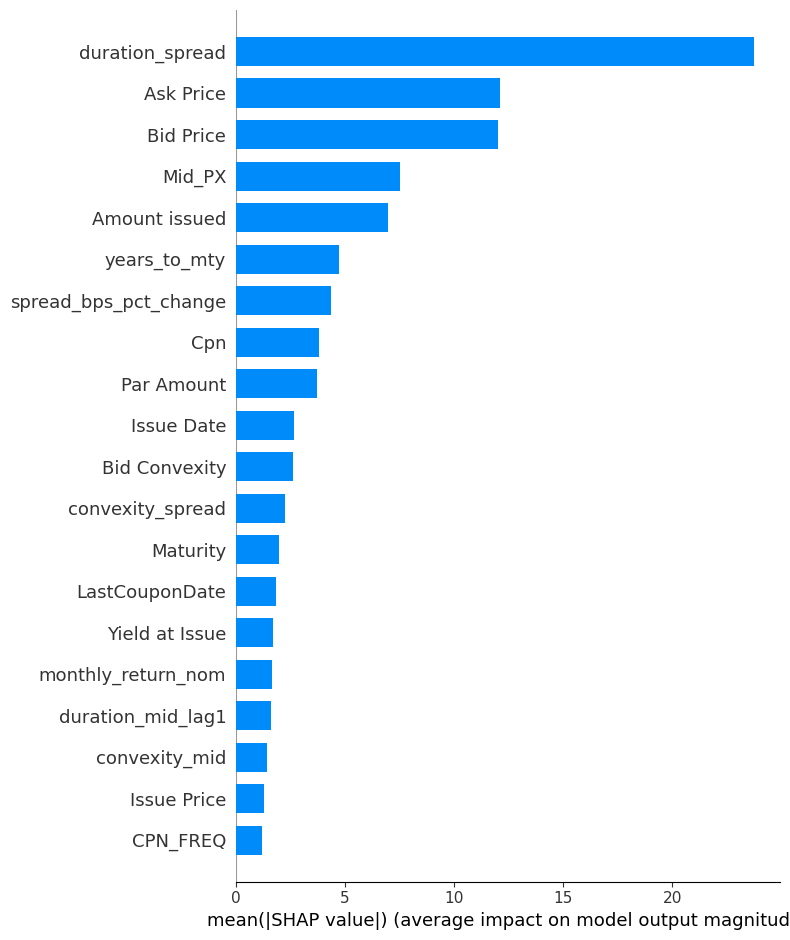

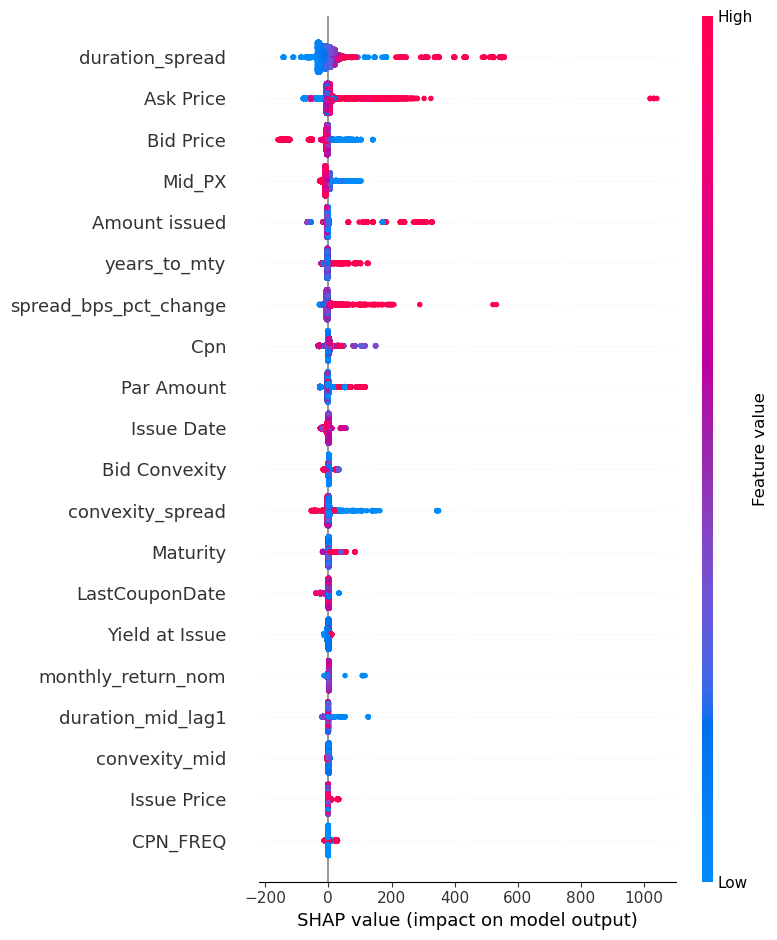

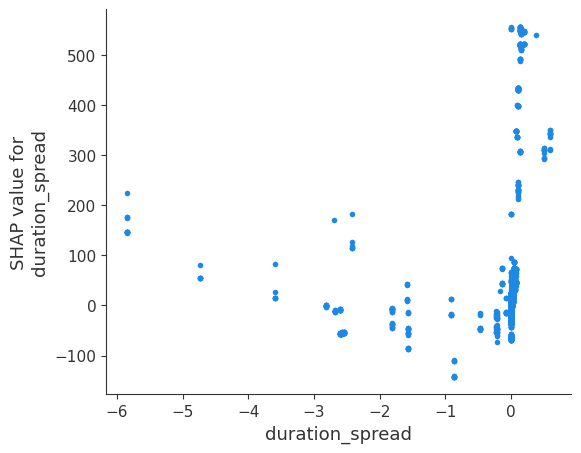

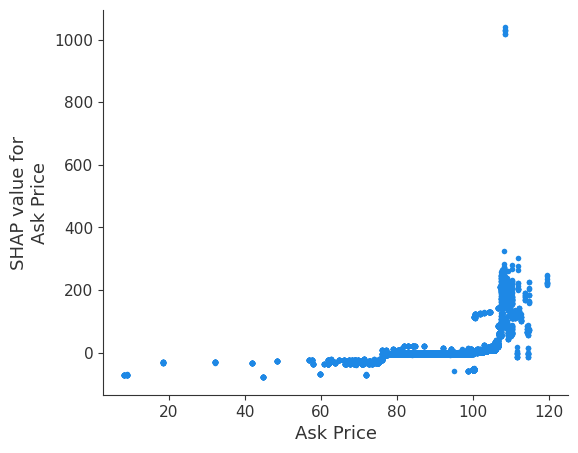

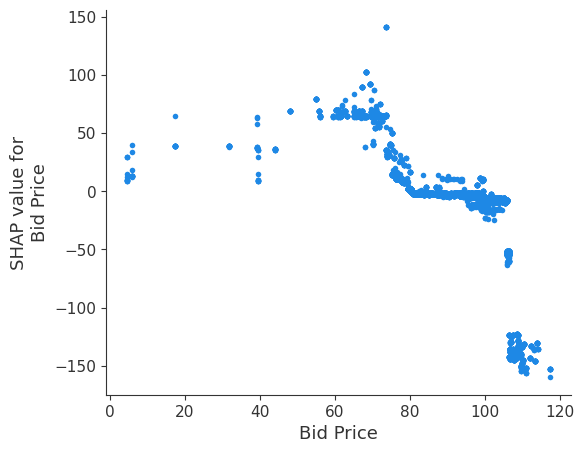

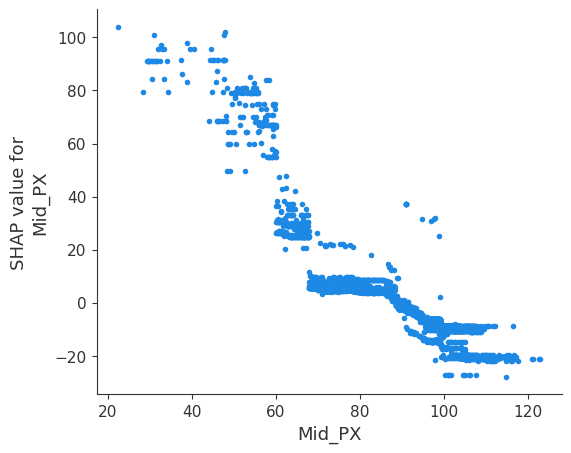

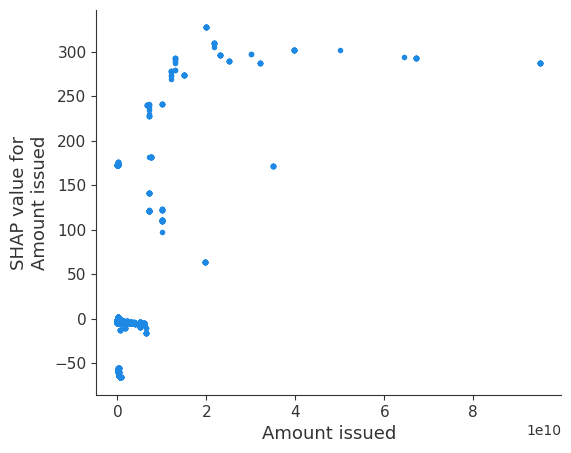

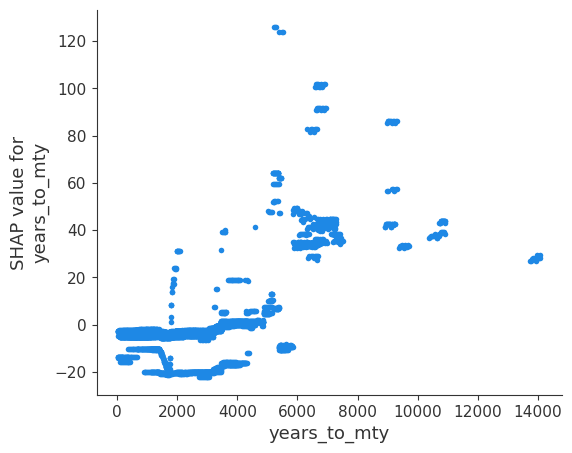


Top XGB features by GAIN:
 duration_mid_lag1     6314853.50
Amount issued         5972665.00
dirty_mid             5843176.00
Issue Date            5721913.00
Accrual period        5367512.00
Par Amount            5350366.00
period_months         4969740.50
Mod Dur (Bid)         4869182.00
Cpn                   4737117.00
CPN_FREQ              4537426.00
years_to_mty          4104304.75
convexity_mid_lag1    3816837.25
NextCouponDate        3456501.75
duration_spread       3255625.75
LastCouponDate        3166181.75
dtype: float64


In [521]:
# =========================================================
# Two–step modeling: Time factor (ElasticNetCV) + XSec (XGBoost)
# with time-aware CV and a final holdout by months
# =========================================================

import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import xgboost as xgb

# -----------------------------
# CONFIG
# -----------------------------
y_col       = "bid_ask_spread_bps"   # target = relative spread in bps
train_frac  = 0.70                    # first 70% of months used for TRAIN
time_splits = 5                       # CV folds on TRAIN part only

# -----------------------------
# HELPERS
# -----------------------------
def evaluate(y_true, y_pred, name="Model"):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    mask = np.isfinite(y_true) & np.isfinite(y_pred)
    r2   = r2_score(y_true[mask], y_pred[mask])
    mae  = mean_absolute_error(y_true[mask], y_pred[mask])
    rmse = float(np.sqrt(mean_squared_error(y_true[mask], y_pred[mask])))
    print(f"{name:28s} | R²={r2:7.3f}  MAE={mae:,.3f}  RMSE={rmse:,.3f}")
    return {"r2": r2, "mae": mae, "rmse": rmse}

def as_float_array(X):
    """
    Return a dense float32 array with ONLY np.nan as missing
    (no pd.NA or ±inf left). Works for DataFrame/ndarray.
    """
    dfX = pd.DataFrame(X) if isinstance(X, np.ndarray) else X.copy()
    dfX = dfX.replace({pd.NA: np.nan, np.inf: np.nan, -np.inf: np.nan})
    for c in dfX.columns:
        dfX[c] = pd.to_numeric(dfX[c], errors="coerce")
    return dfX.to_numpy(dtype=np.float32, copy=False)

def to_numeric_frame(df):
    out = df.copy()
    for c in out.columns:
        out[c] = pd.to_numeric(out[c], errors="coerce")
    out.replace({pd.NA: np.nan, np.inf: np.nan, -np.inf: np.nan}, inplace=True)
    return out

def standardize_df(df):
    # Ensure Date/Ticker exist and are typed
    if "Date" not in df.columns:
        for c in df.columns:
            if "date" in c.lower():
                df = df.rename(columns={c: "Date"})
                break
    if "Ticker" not in df.columns:
        for c in df.columns:
            if "ticker" in c.lower() or "isin" in c.lower():
                df = df.rename(columns={c: "Ticker"})
                break
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
    df = df.dropna(subset=["Date"]).sort_values(["Date", "Ticker"]).reset_index(drop=True)
    return df

# =========================================================
# 1) LOAD / STANDARDIZE / TARGET
# (expects df_encoded to be present in memory)
# =========================================================
df = df_encoded.copy()
df = standardize_df(df)

# Build target if needed
if y_col not in df.columns and {"PX_ASK", "PX_BID", "Mid_PX"}.issubset(df.columns):
    df[y_col] = (df["PX_ASK"] - df["PX_BID"]) / df["Mid_PX"] * 10_000

# Make everything numeric except Date/Ticker
for c in df.columns:
    if c not in ("Date", "Ticker"):
        df[c] = pd.to_numeric(df[c], errors="coerce")
df.replace({pd.NA: np.nan, np.inf: np.nan, -np.inf: np.nan}, inplace=True)

# =========================================================
# 2) TIME-ONLY vs CROSS-SECTIONAL features
# (time-only = constant across bonds within each month)
# =========================================================
month = df["Date"].dt.to_period("M")
all_feat_cols = [c for c in df.columns if c not in ["Date", "Ticker", y_col]]

is_time = {}
for c in all_feat_cols:
    varies = df.groupby(month)[c].nunique().max() > 1
    is_time[c] = (not varies)

time_cols = [c for c in all_feat_cols if is_time[c]]
xsec_cols = [c for c in all_feat_cols if not is_time[c]]

print(f"Time-only features: {len(time_cols)} | Cross-sectional features: {len(xsec_cols)}")

# =========================================================
# 3) TIME FACTOR (ElasticNetCV on monthly mean target)
# =========================================================
# Monthly mean target
mret = (df[["Date", y_col]]
        .dropna(subset=[y_col])
        .assign(ym=lambda d: d["Date"].dt.to_period("M"))
        .groupby("ym")[y_col].mean())

# Macro design: one row per Date, time-only features
macro = df[["Date"] + time_cols].drop_duplicates("Date").copy()
macro["ym"] = macro["Date"].dt.to_period("M")
macro = macro.merge(mret.rename("y_time"), left_on="ym", right_index=True, how="left")
macro = macro.set_index("Date")
macro = to_numeric_frame(macro)

num_time_cols = [c for c in time_cols if not macro[c].isna().all()]
if not num_time_cols:
    raise ValueError("No usable time-only numeric features (all-NaN). Add macro/index/rate columns.")

# Month split for time model
uniq_months = macro.index.to_period("M").unique()
cut = int(len(uniq_months) * train_frac)
train_months = set(uniq_months[:cut])

mask_train_time = macro.index.to_period("M").isin(train_months) & macro["y_time"].notna()
X_time_tr = macro.loc[mask_train_time, num_time_cols]
y_time_tr = macro.loc[mask_train_time, "y_time"].astype(float).values

# Impute X (never y)
imp_time = SimpleImputer(strategy="median").fit(as_float_array(X_time_tr))
X_time_tr_imp = imp_time.transform(as_float_array(X_time_tr))

time_pipe = ElasticNetCV(
    l1_ratio=[0.1, 0.5, 0.9],
    alphas=np.logspace(-2, 2, 20),
    max_iter=5000,
    n_jobs=-1,
    cv=TimeSeriesSplit(n_splits=3)  # time-aware CV inside the time model
)
time_pipe.fit(X_time_tr_imp, y_time_tr)

# Predict time factor for ALL dates, merge back
X_time_all_imp = imp_time.transform(as_float_array(macro[num_time_cols]))
time_pred = pd.Series(time_pipe.predict(X_time_all_imp), index=macro.index, name="time_pred")

df = df.merge(time_pred, left_on="Date", right_index=True, how="left")
df["residual"] = df[y_col].astype(float) - df["time_pred"].astype(float)
df["ym"] = df["Date"].dt.to_period("M")

# =========================================================
# 4) TRAIN / TEST split by month (holdout = last 30% months)
# =========================================================
all_months = df["ym"].unique()
cut2 = int(len(all_months) * train_frac)
train_months2 = set(all_months[:cut2])
mask_tr = df["ym"].isin(train_months2)
mask_te = ~mask_tr

# Cross-sectional matrices
X_full = to_numeric_frame(df[xsec_cols])
y_full = df["residual"].astype(float)

X_tr_all = X_full.loc[mask_tr].copy()
y_tr_all = y_full.loc[mask_tr].copy()
X_te_all = X_full.loc[mask_te].copy()
y_te_all = y_full.loc[mask_te].copy()

# Drop all-NaN & zero-variance cols on TRAIN; align TEST
non_all_nan = ~X_tr_all.isna().all(axis=0)
X_tr_all = X_tr_all.loc[:, non_all_nan]
zero_var = X_tr_all.nunique(dropna=True) <= 1
X_tr_all = X_tr_all.loc[:, ~zero_var]
X_te_all  = X_te_all[X_tr_all.columns].copy()

xsec_cols_clean = X_tr_all.columns.to_list()
print(f"Cross-sectional features used: {len(xsec_cols_clean)}")

# =========================================================
# 5) CROSS-SECTIONAL CV (TimeSeriesSplit) with XGBoost
# =========================================================
Xt_tr = X_tr_all.values
yt_tr = y_tr_all.values
tscv = TimeSeriesSplit(n_splits=time_splits)
print(f"CV folds (TimeSeriesSplit): {time_splits}")

xgb_params = {
    "objective": "reg:squarederror",
    "eta": 0.02,
    "max_depth": 2,
    "min_child_weight": 50,
    "subsample": 0.6,
    "colsample_bytree": 0.6,
    "lambda": 10.0,
    "alpha": 5.0,
    "tree_method": "hist",
    "eval_metric": "rmse",
    "seed": 42,
}

cv_metrics = []
for fold, (tr_idx, val_idx) in enumerate(tscv.split(Xt_tr), start=1):
    # Fold slices
    X_tr, X_val = Xt_tr[tr_idx], Xt_tr[val_idx]
    y_tr, y_val = yt_tr[tr_idx], yt_tr[val_idx]

    # DataFrames to enforce alignment & coercion
    X_tr_df  = pd.DataFrame(X_tr,  columns=xsec_cols_clean)
    X_val_df = pd.DataFrame(X_val, columns=xsec_cols_clean)

    # Coerce to numeric; remove pd.NA/±inf
    for df_ in (X_tr_df, X_val_df):
        for c in df_.columns:
            df_[c] = pd.to_numeric(df_[c], errors="coerce")
        df_.replace({pd.NA: np.nan, np.inf: np.nan, -np.inf: np.nan}, inplace=True)

    # Drop all-NaN columns on TRAIN fold; align VAL
    keep_cols = X_tr_df.columns[~X_tr_df.isna().all(axis=0)]
    X_tr_df  = X_tr_df[keep_cols]
    X_val_df = X_val_df[keep_cols]

    # Float arrays
    X_tr  = as_float_array(X_tr_df)
    X_val = as_float_array(X_val_df)
    y_tr  = pd.to_numeric(pd.Series(y_tr), errors="coerce").astype(float).to_numpy()
    y_val = pd.to_numeric(pd.Series(y_val), errors="coerce").astype(float).to_numpy()

    # Impute on TRAIN, apply to VAL
    imp = SimpleImputer(strategy="median").fit(X_tr)
    X_tr  = imp.transform(X_tr)
    X_val = imp.transform(X_val)

    # Ensure labels are finite (XGBoost requirement)
    m_tr  = np.isfinite(y_tr)
    m_val = np.isfinite(y_val)
    X_tr, y_tr = X_tr[m_tr], y_tr[m_tr].astype(np.float32, copy=False)
    X_val, y_val = X_val[m_val], y_val[m_val].astype(np.float32, copy=False)

    dtrain = xgb.DMatrix(X_tr,  label=y_tr)   # features may contain NaN; labels must not
    dvalid = xgb.DMatrix(X_val, label=y_val)

    booster = xgb.train(
        params=xgb_params,
        dtrain=dtrain,
        num_boost_round=3000,
        evals=[(dtrain, "train"), (dvalid, "valid")],
        early_stopping_rounds=200,
        verbose_eval=False
    )

    y_val_pred = booster.predict(dvalid, iteration_range=(0, booster.best_iteration + 1))
    cv_metrics.append(evaluate(y_val, y_val_pred, name=f"Fold {fold}"))

# =========================================================
# 6) FINAL fit on all TRAIN rows, evaluate on hold-out months
# =========================================================
Xtr_final = as_float_array(X_tr_all)
Xte_final = as_float_array(X_te_all)

imp_final = SimpleImputer(strategy="median").fit(Xtr_final)
Xtr_final = imp_final.transform(Xtr_final)
Xte_final = imp_final.transform(Xte_final)

y_tr_final = y_tr_all.values.astype(np.float32, copy=False)
y_te_final = y_te_all.values.astype(np.float32, copy=False)

m_tr_final = np.isfinite(y_tr_final)
m_te_final = np.isfinite(y_te_final)

Xtr_final = Xtr_final[m_tr_final]
y_tr_final = y_tr_final[m_tr_final]

Xte_final = Xte_final[m_te_final]
y_te_final = y_te_final[m_te_final]

dtrain_final = xgb.DMatrix(Xtr_final, label=y_tr_final)
dtest_final  = xgb.DMatrix(Xte_final)

booster_final = xgb.train(
    params=xgb_params,
    dtrain=dtrain_final,
    num_boost_round=3000,
    evals=[(dtrain_final, "train")],
    early_stopping_rounds=200,
    verbose_eval=False
)

y_test_pred = booster_final.predict(dtest_final, iteration_range=(0, booster_final.best_iteration + 1))
print("\n=== FINAL hold-out (last 30% months) ===")
evaluate(y_te_final, y_test_pred, name="Two-step: Time(EN) + XSec(XGB)")

# --- SHAP: explain what drives spreads on the hold-out set -------------------
# (if you don't have shap: pip install shap)
import numpy as np
import pandas as pd
import shap

# 1) Wrap your train/test matrices with column names for readability
Xtr_df = pd.DataFrame(Xtr_final, columns=xsec_cols_clean)
Xte_df = pd.DataFrame(Xte_final, columns=xsec_cols_clean)

# 2) Build a SHAP explainer for the trained XGBoost Booster
#    (TreeExplainer is fast & exact for tree ensembles)
explainer = shap.TreeExplainer(booster_final)

# Use a small background sample from TRAIN to speed up expected value estimation
# (optional but recommended for big datasets)
bg = Xtr_df.sample(min(1000, len(Xtr_df)), random_state=42)

# Compute SHAP values for the hold-out (these are per-feature contributions in y-units)
# Note: for some SHAP / xgboost versions, you may need: explainer.shap_values(Xte_df)
shap_values = explainer.shap_values(Xte_df, y=None, tree_limit=booster_final.best_iteration)

# 3) Global importance (which factors matter most, on average)
print("\nTop features by mean(|SHAP|) on the hold-out:")
mean_abs = np.abs(shap_values).mean(axis=0)
shap_ranking = pd.Series(mean_abs, index=Xte_df.columns).sort_values(ascending=False)
print(shap_ranking.head(20))

# 4) Summary plots
# Bar plot = global ranking; Beeswarm = direction + distribution of impacts
shap.summary_plot(shap_values, Xte_df, plot_type="bar", max_display=20)
shap.summary_plot(shap_values, Xte_df, max_display=20)  # beeswarm

# 5) Dependence plots for the top drivers (marginal effect curves)
top_feats = shap_ranking.index[:6]  # pick a few
for f in top_feats:
    shap.dependence_plot(f, shap_values, Xte_df, interaction_index=None)  # set another feature to see interactions

# Feature importance (GAIN)
gain = booster_final.get_score(importance_type="gain")
feat_map = {f"f{i}": col for i, col in enumerate(xsec_cols_clean)}
gain_series = pd.Series({feat_map[k]: v for k, v in gain.items()}).sort_values(ascending=False)
print("\nTop XGB features by GAIN:\n", gain_series.head(15))

In [522]:
# =========================================================
# Two-step Model: Time Factor (ElasticNetCV) + Cross-sectional (XGBoost)
# Target: bid-ask spread in basis points
# =========================================================

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from sklearn.impute import SimpleImputer
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import xgboost as xgb

# -----------------------------
# CONFIGURATION
# -----------------------------
CONFIG = {
    'y_col': 'bid_ask_spread_bps',
    'train_frac': 0.70,
    'cv_splits': 5,
    'random_seed': 42,
    'xgb_params': {
        'objective': 'reg:squarederror',
        'eta': 0.02,
        'max_depth': 2,
        'min_child_weight': 50,
        'subsample': 0.6,
        'colsample_bytree': 0.6,
        'lambda': 10.0,
        'alpha': 5.0,
        'tree_method': 'hist',
        'eval_metric': 'rmse',
        'seed': 42,
    },
    'xgb_rounds': 3000,
    'early_stopping': 200
}

# -----------------------------
# UTILITY FUNCTIONS
# -----------------------------
def evaluate_model(y_true, y_pred, name="Model"):
    """Calculate and print model evaluation metrics."""
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    
    # Filter out non-finite values
    mask = np.isfinite(y_true) & np.isfinite(y_pred)
    if mask.sum() == 0:
        print(f"{name:30s} | No valid predictions")
        return {"r2": np.nan, "mae": np.nan, "rmse": np.nan}
    
    y_true_clean = y_true[mask]
    y_pred_clean = y_pred[mask]
    
    r2 = r2_score(y_true_clean, y_pred_clean)
    mae = mean_absolute_error(y_true_clean, y_pred_clean)
    rmse = np.sqrt(mean_squared_error(y_true_clean, y_pred_clean))
    
    print(f"{name:30s} | R²={r2:7.4f}  MAE={mae:8.3f}  RMSE={rmse:8.3f}")
    return {"r2": r2, "mae": mae, "rmse": rmse}

def clean_numeric_data(df, exclude_cols=None):
    """Convert DataFrame to numeric and handle infinite/missing values."""
    exclude_cols = exclude_cols or []
    df_clean = df.copy()
    
    for col in df_clean.columns:
        if col not in exclude_cols:
            df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
    
    # Replace infinities with NaN
    df_clean.replace([np.inf, -np.inf], np.nan, inplace=True)
    return df_clean

def prepare_data(df):
    """Standardize and prepare the input dataframe."""
    df = df.copy()
    
    # Ensure Date and Ticker columns exist
    date_cols = [c for c in df.columns if 'date' in c.lower()]
    ticker_cols = [c for c in df.columns if 'ticker' in c.lower() or 'isin' in c.lower()]
    
    if 'Date' not in df.columns and date_cols:
        df.rename(columns={date_cols[0]: 'Date'}, inplace=True)
    if 'Ticker' not in df.columns and ticker_cols:
        df.rename(columns={ticker_cols[0]: 'Ticker'}, inplace=True)
    
    # Convert Date to datetime
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
        df = df.dropna(subset=['Date'])
    
    # Sort by Date and Ticker
    sort_cols = [c for c in ['Date', 'Ticker'] if c in df.columns]
    if sort_cols:
        df = df.sort_values(sort_cols).reset_index(drop=True)
    
    return df

def create_target_variable(df, y_col):
    """Create bid-ask spread target if it doesn't exist."""
    if y_col not in df.columns:
        required_cols = {'PX_ASK', 'PX_BID', 'Mid_PX'}
        if required_cols.issubset(df.columns):
            df[y_col] = (df['PX_ASK'] - df['PX_BID']) / df['Mid_PX'] * 10000
            print(f"Created target variable: {y_col}")
        else:
            raise ValueError(f"Cannot create {y_col}: missing required columns {required_cols}")
    return df

def identify_feature_types(df, feature_cols):
    """Separate time-only and cross-sectional features."""
    df['month'] = df['Date'].dt.to_period('M')
    
    time_only_features = []
    cross_sectional_features = []
    
    for col in feature_cols:
        # Check if feature varies within each month
        monthly_variance = df.groupby('month')[col].nunique(dropna=False)
        is_time_only = (monthly_variance <= 1).all()
        
        if is_time_only:
            time_only_features.append(col)
        else:
            cross_sectional_features.append(col)
    
    return time_only_features, cross_sectional_features

# -----------------------------
# MAIN MODELING PIPELINE
# -----------------------------
def run_two_step_model(df_input):
    """Execute the two-step modeling pipeline."""
    
    print("="*60)
    print("TWO-STEP MODELING PIPELINE")
    print("="*60)
    
    # Step 1: Data Preparation
    print("\n1. DATA PREPARATION")
    print("-"*40)
    
    df = prepare_data(df_input)
    df = create_target_variable(df, CONFIG['y_col'])
    df = clean_numeric_data(df, exclude_cols=['Date', 'Ticker'])
    
    # Identify feature columns
    exclude = ['Date', 'Ticker', CONFIG['y_col'], 'month']
    all_features = [c for c in df.columns if c not in exclude]
    
    # Step 2: Feature Type Identification
    print("\n2. FEATURE SEPARATION")
    print("-"*40)
    
    time_features, xsec_features = identify_feature_types(df, all_features)
    print(f"Time-only features: {len(time_features)}")
    print(f"Cross-sectional features: {len(xsec_features)}")
    
    if not time_features:
        raise ValueError("No time-only features found. Add macro/market features.")
    if not xsec_features:
        raise ValueError("No cross-sectional features found.")
    
    # Step 3: Time Factor Model
    print("\n3. TIME FACTOR MODEL (ElasticNet)")
    print("-"*40)
    
    # Create monthly aggregated data for time model
    df['month'] = df['Date'].dt.to_period('M')
    monthly_target = df.groupby('month')[CONFIG['y_col']].mean()
    
    # Prepare time-only feature matrix
    time_data = df[['Date'] + time_features].drop_duplicates('Date').copy()
    time_data['month'] = time_data['Date'].dt.to_period('M')
    time_data = time_data.merge(
        monthly_target.rename('y_monthly'), 
        left_on='month', 
        right_index=True, 
        how='left'
    )
    
    # Split time data
    unique_months = sorted(time_data['month'].unique())
    n_train_months = int(len(unique_months) * CONFIG['train_frac'])
    train_months = set(unique_months[:n_train_months])
    
    # Prepare training data for time model
    train_mask = time_data['month'].isin(train_months) & time_data['y_monthly'].notna()
    X_time_train = time_data.loc[train_mask, time_features]
    y_time_train = time_data.loc[train_mask, 'y_monthly']
    
    # Impute and train time model
    time_imputer = SimpleImputer(strategy='median')
    X_time_train_imp = time_imputer.fit_transform(X_time_train)
    
    time_model = ElasticNetCV(
        l1_ratio=[0.1, 0.5, 0.9],
        alphas=np.logspace(-2, 2, 20),
        max_iter=5000,
        cv=TimeSeriesSplit(n_splits=3),
        n_jobs=-1
    )
    time_model.fit(X_time_train_imp, y_time_train)
    
    # Generate time predictions for all dates
    X_time_all = time_data[time_features]
    X_time_all_imp = time_imputer.transform(X_time_all)
    time_predictions = time_model.predict(X_time_all_imp)
    
    # Merge time predictions back to main dataframe
    time_pred_df = pd.DataFrame({
        'Date': time_data['Date'],
        'time_factor': time_predictions
    })
    df = df.merge(time_pred_df, on='Date', how='left')
    
    # Calculate residuals
    df['residual'] = df[CONFIG['y_col']] - df['time_factor']
    
    print(f"Time model R² on training: {time_model.score(X_time_train_imp, y_time_train):.4f}")
    
    # Step 4: Cross-sectional Model with CV
    print("\n4. CROSS-SECTIONAL MODEL (XGBoost)")
    print("-"*40)
    
    # Train/test split by months
    all_months = sorted(df['month'].unique())
    n_train = int(len(all_months) * CONFIG['train_frac'])
    train_months_xsec = set(all_months[:n_train])
    
    train_mask = df['month'].isin(train_months_xsec)
    test_mask = ~train_mask
    
    # Prepare features and target
    X_train = df.loc[train_mask, xsec_features]
    y_train = df.loc[train_mask, 'residual']
    X_test = df.loc[test_mask, xsec_features]
    y_test = df.loc[test_mask, 'residual']
    
    # Remove features with no variance in training
    valid_features = X_train.columns[X_train.nunique() > 1].tolist()
    X_train = X_train[valid_features]
    X_test = X_test[valid_features]
    
    print(f"Using {len(valid_features)} cross-sectional features")
    print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")
    
    # Time series cross-validation
    tscv = TimeSeriesSplit(n_splits=CONFIG['cv_splits'])
    cv_scores = []
    
    print(f"\nCross-validation with {CONFIG['cv_splits']} folds:")
    for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train), 1):
        # Get fold data
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        # Impute missing values
        fold_imputer = SimpleImputer(strategy='median')
        X_tr_imp = fold_imputer.fit_transform(X_tr)
        X_val_imp = fold_imputer.transform(X_val)
        
        # Filter finite targets
        mask_tr = np.isfinite(y_tr)
        mask_val = np.isfinite(y_val)
        
        # Train XGBoost
        dtrain = xgb.DMatrix(X_tr_imp[mask_tr], label=y_tr[mask_tr])
        dval = xgb.DMatrix(X_val_imp[mask_val], label=y_val[mask_val])
        
        model = xgb.train(
            params=CONFIG['xgb_params'],
            dtrain=dtrain,
            num_boost_round=CONFIG['xgb_rounds'],
            evals=[(dtrain, 'train'), (dval, 'valid')],
            early_stopping_rounds=CONFIG['early_stopping'],
            verbose_eval=False
        )
        
        # Evaluate fold
        y_pred = model.predict(dval)
        metrics = evaluate_model(y_val[mask_val], y_pred, f"  Fold {fold}")
        cv_scores.append(metrics['r2'])
    
    print(f"\nAverage CV R²: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores):.4f})")
    
    # Step 5: Final Model Training and Evaluation
    print("\n5. FINAL MODEL EVALUATION")
    print("-"*40)
    
    # Train final model on all training data
    final_imputer = SimpleImputer(strategy='median')
    X_train_imp = final_imputer.fit_transform(X_train)
    X_test_imp = final_imputer.transform(X_test)
    
    # Filter finite targets
    mask_train = np.isfinite(y_train)
    mask_test = np.isfinite(y_test)
    
    dtrain_final = xgb.DMatrix(X_train_imp[mask_train], label=y_train[mask_train])
    dtest_final = xgb.DMatrix(X_test_imp[mask_test])
    
    final_model = xgb.train(
        params=CONFIG['xgb_params'],
        dtrain=dtrain_final,
        num_boost_round=CONFIG['xgb_rounds'],
        evals=[(dtrain_final, 'train')],
        early_stopping_rounds=CONFIG['early_stopping'],
        verbose_eval=False
    )
    
    # Final predictions
    y_test_pred = final_model.predict(dtest_final)
    
    print("\nHoldout Test Set Performance (last 30% of months):")
    test_metrics = evaluate_model(y_test[mask_test], y_test_pred, "Two-step Model")
    
    # Feature importance
    print("\n6. TOP FEATURES (by gain)")
    print("-"*40)
    importance = final_model.get_score(importance_type='gain')
    feature_names = valid_features
    importance_df = pd.DataFrame([
        (feature_names[int(k[1:])], v) 
        for k, v in importance.items()
    ], columns=['Feature', 'Gain'])
    importance_df = importance_df.sort_values('Gain', ascending=False)
    
    print(importance_df.head(15).to_string(index=False))
    
    return {
        'time_model': time_model,
        'xgb_model': final_model,
        'time_imputer': time_imputer,
        'xsec_imputer': final_imputer,
        'valid_features': valid_features,
        'test_metrics': test_metrics
    }

# -----------------------------
# EXECUTION
# -----------------------------
if __name__ == "__main__":
    try:
        # Assumes df_encoded exists in memory
        if 'df_encoded' not in locals():
            raise NameError("df_encoded not found in memory. Please load your data first.")
        
        # Run the pipeline
        results = run_two_step_model(df_encoded)
        
        print("\n" + "="*60)
        print("PIPELINE COMPLETED SUCCESSFULLY")
        print("="*60)
        
    except Exception as e:
        print(f"\nERROR: {str(e)}")
        import traceback
        traceback.print_exc()

TWO-STEP MODELING PIPELINE

1. DATA PREPARATION
----------------------------------------

2. FEATURE SEPARATION
----------------------------------------
Time-only features: 134
Cross-sectional features: 35

3. TIME FACTOR MODEL (ElasticNet)
----------------------------------------
Time model R² on training: 0.6916

4. CROSS-SECTIONAL MODEL (XGBoost)
----------------------------------------
Using 35 cross-sectional features
Training samples: 30113, Test samples: 22081

Cross-validation with 5 folds:
  Fold 1                       | R²= 0.7724  MAE=  44.778  RMSE=  78.984
  Fold 2                       | R²= 0.4657  MAE=  37.233  RMSE= 210.698
  Fold 3                       | R²= 0.5545  MAE=  37.447  RMSE=  68.278
  Fold 4                       | R²= 0.7980  MAE=  26.319  RMSE=  51.821
  Fold 5                       | R²= 0.7733  MAE=  26.172  RMSE=  52.791

Average CV R²: 0.6728 (+/- 0.1361)

5. FINAL MODEL EVALUATION
----------------------------------------

Holdout Test Set Performan

In [476]:
bad_cols = [c for c in X_tr_all.columns if np.isinf(X_tr_all[c]).any()]
print(bad_cols)

[]


In [484]:
print("X_tr dtype:", getattr(X_tr, "dtype", "df"))
print("Any pd.NA in X_tr? ->", any((pd.isna(pd.Series(X_tr.ravel(), dtype="object")))))

X_tr dtype: object
Any pd.NA in X_tr? -> True


In [501]:
bad = df.select_dtypes(include=["object", "boolean"]).columns.tolist()
nullable_int = [c for c in df.columns if str(df[c].dtype).lower() in ("int64", "uint64", "int32", "uint32", "Int64", "UInt64", "boolean")]
print("Object/boolean columns:", bad)
print("Nullable integer/boolean columns:", nullable_int[:20], "… total", len(nullable_int))

Object/boolean columns: []
Nullable integer/boolean columns: ['Issue Date', 'Maturity', 'CPN_FREQ', 'LastCouponDate', 'NextCouponDate', 'row_in_bond'] … total 6


In [ ]:
#Dropping unneccesary variables
final_merge = final_merge.drop('Classification', axis=1)

In [107]:
Extraction = ['Ticker','Amount issued','Issuer Name','Issue Date','Maturity','Cpn']

In [108]:
Extraction_1 = final_2[Extraction]

In [75]:
Extraction_1 = Extraction_1.drop_duplicates()

In [76]:
Extraction_1.to_csv('/Users/marcohattingh/Desktop/Research Assignment/Data/SRCH_EXTRACT.csv', index=True)


In [72]:
Extraction_2 = ['Ticker']
Extraction_2_1 = final_2[Extraction_2]
Extraction_2_2 =Extraction_2_1.drop_duplicates()
Extraction_2_2.to_excel('/Users/marcohattingh/Desktop/Research Assignment/Data/ISIN_CPN_FREQ.xlsx', index=False)

In [661]:
to_drop = ['PX_ASK','PX_BID','YLD_YTM_ASK','YLD_YTM_BID', 'Ticker']
X = final_2.drop(columns= to_drop)
y = final_2['YLD_YTM_ASK']

In [532]:
list1 = final_merge['BICS Level 2'].unique().to_list()
    
print(list1)

['Real Estate', 'Industrial Other', 'Forest & Paper Products Manufacturing', 'Power Generation', 'Waste & Environment Services & Equipment', 'Utilities', 'Government Development Banks', 'Government Regional', 'Containers & Packaging', 'Consumer Finance', 'Renewable Energy', 'Banks', 'Financial Services', 'Transportation & Logistics', 'Travel & Lodging', 'Commercial Finance', 'Wireline Telecommunications Services', 'Chemicals', 'Wireless Telecommunications Services', 'Diversified Banks', 'Consumer Products', 'Railroad', 'Life Insurance', 'Cable & Satellite', 'Funds & Trusts', 'Automobiles Manufacturing', 'Auto Parts Manufacturing', 'Refining & Marketing', 'Food & Beverage', 'Integrated Oils', 'Construction Materials Manufacturing', 'Property & Casualty Insurance', 'Homebuilders', 'Health Care Facilities & Services', 'Distributors - Consumer Discretionary', 'Home Improvement', 'Medical Equipment & Devices Manufacturing', 'Semiconductors', 'Electrical Equipment Manufacturing', 'Retail - C

In [534]:
maindf['S&P500 VOLATILITY INDEX'].corr(maindf['EURO STOXX 50 VOLATILITY'])


0.9344267872957249

In [538]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# ============================================
# STEP 0: FIX DATETIME COLUMNS FIRST
# ============================================

def prepare_datetime_features(df):
    """
    Convert datetime columns to numeric features
    """
    df = df.copy()
    
    date_columns = ['NextCouponDate', 'LastCouponDate', 'Issue Date', 'Maturity', 'Date']
    
    for col in date_columns:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')
            df[f'{col}_numeric'] = (df[col] - pd.Timestamp('1970-01-01')).dt.total_seconds() / 86400
    
    # Create coupon timing features
    if 'NextCouponDate' in df.columns and 'Date' in df.columns:
        df['days_to_next_coupon'] = (pd.to_datetime(df['NextCouponDate']) - pd.to_datetime(df['Date'])).dt.days
    if 'LastCouponDate' in df.columns and 'Date' in df.columns:
        df['days_since_last_coupon'] = (pd.to_datetime(df['Date']) - pd.to_datetime(df['LastCouponDate'])).dt.days
    
    print("✓ Datetime features converted to numeric")
    return df

maindf = prepare_datetime_features(maindf)

# ============================================
# STEP 1: SECTOR CATEGORIZATION
# ============================================

def categorize_sectors(df):
    """Group BICS Level 2 into meaningful categories"""
    df = df.copy()
    
    sector_mapping = {
        'Power Generation': 'Energy & Utilities',
        'Renewable Energy': 'Energy & Utilities',
        'Utilities': 'Energy & Utilities',
        'Integrated Oils': 'Energy & Utilities',
        'Refining & Marketing': 'Energy & Utilities',
        'Coal Operations': 'Energy & Utilities',
        
        'Banks': 'Financial Services',
        'Diversified Banks': 'Financial Services',
        'Consumer Finance': 'Financial Services',
        'Commercial Finance': 'Financial Services',
        'Financial Services': 'Financial Services',
        'Life Insurance': 'Financial Services',
        'Property & Casualty Insurance': 'Financial Services',
        
        'Real Estate': 'Real Estate & Construction',
        'Homebuilders': 'Real Estate & Construction',
        'Construction Materials Manufacturing': 'Real Estate & Construction',
        
        'Transportation & Logistics': 'Transportation',
        'Railroad': 'Transportation',
        'Automobiles Manufacturing': 'Transportation',
        'Auto Parts Manufacturing': 'Transportation',
        
        'Industrial Other': 'Industrial & Manufacturing',
        'Machinery Manufacturing': 'Industrial & Manufacturing',
        'Electrical Equipment Manufacturing': 'Industrial & Manufacturing',
        'Manufactured Goods': 'Industrial & Manufacturing',
        'Chemicals': 'Industrial & Manufacturing',
        'Metals & Mining': 'Industrial & Manufacturing',
        
        'Waste & Environment Services & Equipment': 'Environmental Services',
        
        'Government Development Banks': 'Government & Supranationals',
        'Government Regional': 'Government & Supranationals',
        'Government Local': 'Government & Supranationals',
        'Supranationals': 'Government & Supranationals',
        
        'Wireline Telecommunications Services': 'Technology & Telecom',
        'Wireless Telecommunications Services': 'Technology & Telecom',
        'Cable & Satellite': 'Technology & Telecom',
        'Communications Equipment': 'Technology & Telecom',
        'Hardware': 'Technology & Telecom',
        'Semiconductors': 'Technology & Telecom',
        
        'Consumer Products': 'Consumer & Retail',
        'Food & Beverage': 'Consumer & Retail',
        'Retail - Consumer Discretionary': 'Consumer & Retail',
        'Distributors - Consumer Discretionary': 'Consumer & Retail',
        'Supermarkets & Pharmacies': 'Consumer & Retail',
        'Home Improvement': 'Consumer & Retail',
        'Travel & Lodging': 'Consumer & Retail',
        
        'Forest & Paper Products Manufacturing': 'Other',
        'Containers & Packaging': 'Other',
        'Health Care Facilities & Services': 'Other',
        'Medical Equipment & Devices Manufacturing': 'Other',
        'Funds & Trusts': 'Other',
        'Entertainment Resources': 'Other'
    }
    
    df['sector_group'] = df['BICS Level 2'].map(sector_mapping).fillna('Other')
    
    print("\n" + "="*70)
    print("SECTOR DISTRIBUTION")
    print("="*70)
    print("\nTop 10 BICS Level 2 sectors:")
    print(df['BICS Level 2'].value_counts().head(10))
    print("\nSector groups:")
    print(df['sector_group'].value_counts())
    
    return df

maindf = categorize_sectors(maindf)

# ============================================
# STEP 2: STOXX VOLATILITY REGIMES
# ============================================

def create_stoxx_volatility_regimes(df):
    """Create volatility regimes using EURO STOXX 50 VOLATILITY"""
    df = df.copy()
    
    vol_col = 'EURO STOXX 50 VOLATILITY'
    
    vol_25 = df[vol_col].quantile(0.25)
    vol_75 = df[vol_col].quantile(0.75)
    vol_90 = df[vol_col].quantile(0.90)
    
    df['high_stoxx_vol'] = (df[vol_col] > vol_75).astype(int)
    df['low_stoxx_vol'] = (df[vol_col] < vol_25).astype(int)
    df['extreme_stoxx_vol'] = (df[vol_col] > vol_90).astype(int)
    
    df['stoxx_vol_regime'] = 'Normal'
    df.loc[df[vol_col] < vol_25, 'stoxx_vol_regime'] = 'Low Volatility'
    df.loc[df[vol_col] > vol_75, 'stoxx_vol_regime'] = 'High Volatility'
    df.loc[df[vol_col] > vol_90, 'stoxx_vol_regime'] = 'Extreme Stress'
    
    df['stoxx_vol_ma'] = df[vol_col].rolling(20).mean()
    df['stoxx_vol_elevated'] = (df[vol_col] > df['stoxx_vol_ma']).astype(int)
    
    print(f"\n✓ STOXX volatility regimes created")
    print(f"  Low: <{vol_25:.1f}, High: >{vol_75:.1f}, Extreme: >{vol_90:.1f}")
    
    return df

maindf = create_stoxx_volatility_regimes(maindf)

# ============================================
# STEP 3: ADDITIONAL FEATURES
# ============================================

def create_enhanced_features(df):
    """Create complementary features"""
    df = df.copy()
    
    # Credit quality
    rating_map = {
        'AAA': 1, 'AA+': 2, 'AA': 3, 'AA-': 4,
        'A+': 5, 'A': 6, 'A-': 7,
        'BBB+': 8, 'BBB': 9, 'BBB-': 10,
        'BB+': 11, 'BB': 12, 'BB-': 13,
        'B+': 14, 'B': 15, 'B-': 16,
        'CCC+': 17, 'CCC': 18, 'CCC-': 19
    }
    
    df['rating_numeric'] = df['BBG Composite'].map(rating_map)
    df['is_investment_grade'] = (df['rating_numeric'] <= 10).astype(int)
    
    # Maturity buckets
    df['maturity_bucket'] = pd.cut(df['years_to_mty'], 
                                    bins=[0, 3, 7, 15, 100],
                                    labels=['Short', 'Medium', 'Long', 'Very Long'])
    
    # Issue size
    df['issue_size_category'] = pd.qcut(df['Amount issued'], 
                                         q=4, 
                                         labels=['Small', 'Medium', 'Large', 'Very Large'],
                                         duplicates='drop')
    
    # Age
    df['years_since_issue'] = (pd.to_datetime(df['Date']) - 
                                pd.to_datetime(df['Issue Date'])).dt.days / 365.25
    df['is_seasoned'] = (df['years_since_issue'] > 2).astype(int)
    
    # Market indicators
    df['stoxx_momentum'] = df['EURO STOXX 50'].pct_change(20)
    df['yield_curve_slope'] = df['GERMANY 10-YEAR BOND YTM_BID'] - df['GERMANY 2-YEAR BOND YTM_BID']
    df['yield_curve_steep'] = (df['yield_curve_slope'] > df['yield_curve_slope'].median()).astype(int)
    df['renewable_momentum'] = df['EUROPEAN RENEWABLE ENERGY INDEX'].pct_change(20)
    
    print("✓ Enhanced features created")
    return df

maindf = create_enhanced_features(maindf)

# ============================================
# STEP 4: INTERACTION TERMS
# ============================================

def create_sector_interactions(df):
    """Create sector-specific interactions"""
    df = df.copy()
    
    df['duration_x_stoxx_vol'] = df['duration_mid_lag1'] * df['EURO STOXX 50 VOLATILITY']
    df['amount_x_stoxx_vol'] = df['Amount issued'] * df['EURO STOXX 50 VOLATILITY']
    df['rating_x_stoxx_vol'] = df['rating_numeric'] * df['EURO STOXX 50 VOLATILITY']
    
    df['is_renewable_energy'] = (df['BICS Level 2'] == 'Renewable Energy').astype(int)
    df['is_utilities'] = (df['BICS Level 2'].isin(['Utilities', 'Power Generation'])).astype(int)
    df['is_bank'] = (df['BICS Level 2'].str.contains('Bank', na=False)).astype(int)
    
    print("✓ Interaction terms created")
    return df

maindf = create_sector_interactions(maindf)

# ============================================
# STEP 5: ENCODE CATEGORICAL
# ============================================

def encode_features(df):
    """Encode categorical variables"""
    df = df.copy()
    encoders = {}
    
    categorical_cols = [
        'BICS Level 2',
        'sector_group',
        'stoxx_vol_regime',
        'maturity_bucket',
        'issue_size_category',
        'Country',
        'Currency'
    ]
    
    print("\nEncoding categorical variables:")
    for col in categorical_cols:
        if col in df.columns:
            le = LabelEncoder()
            df[f'{col}_encoded'] = le.fit_transform(df[col].astype(str))
            encoders[col] = le
            print(f"  ✓ {col}: {len(le.classes_)} categories")
    
    return df, encoders

maindf, label_encoders = encode_features(maindf)

# ============================================
# STEP 6: DEFINE FEATURES (FIXED)
# ============================================

# Original features - DATETIME COLUMNS REPLACED
original_features = [
    'duration_mid_lag1',
    'Amount issued',
    'dirty_mid',
    'Accrual period',
    'Par Amount',
    'period_months',
    'Mod Dur (Bid)',
    'Cpn',
    'CPN_FREQ',
    'years_to_mty',
    'convexity_mid_lag1',
    'duration_spread',
    # Numeric versions of datetime columns:
    'days_to_next_coupon',
    'days_since_last_coupon'
]

# New features
new_features = [
    'BICS Level 2_encoded',
    'sector_group_encoded',
    'is_renewable_energy',
    'is_utilities',
    'is_bank',
    'high_stoxx_vol',
    'low_stoxx_vol',
    'extreme_stoxx_vol',
    'stoxx_vol_regime_encoded',
    'stoxx_vol_elevated',
    'rating_numeric',
    'is_investment_grade',
    'maturity_bucket_encoded',
    'issue_size_category_encoded',
    'years_since_issue',
    'is_seasoned',
    'yield_curve_slope',
    'yield_curve_steep',
    'stoxx_momentum',
    'renewable_momentum',
    'duration_x_stoxx_vol',
    'amount_x_stoxx_vol',
    'rating_x_stoxx_vol'
]

# Combine and filter
all_features = [f for f in original_features + new_features if f in maindf.columns]

# CRITICAL: Final check for datetime columns
datetime_cols = maindf[all_features].select_dtypes(include=['datetime64']).columns.tolist()
if datetime_cols:
    print(f"\n⚠️  Removing datetime columns: {datetime_cols}")
    all_features = [f for f in all_features if f not in datetime_cols]

print("\n" + "="*70)
print("FINAL FEATURE SET")
print("="*70)
print(f"Total features: {len(all_features)}")
print(f"✓ All features are numeric/categorical")

# Verify no datetime columns remain
print("\nData type check:")
dtypes = maindf[all_features].dtypes.value_counts()
print(dtypes)

# ============================================
# STEP 7: TRAIN MODEL
# ============================================

def train_sector_model(df, features, target='bid_ask_spread_bps', n_splits=5):
    """Train model with sector features"""
    
    # Drop rows with missing values
    df_model = df.dropna(subset=features + [target])
    X = df_model[features]
    y = df_model[target]
    
    # Final safety check
    assert X.select_dtypes(include=['datetime64']).shape[1] == 0, "Datetime columns still present!"
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    results = []
    models = []
    
    print("\n" + "="*70)
    print("TRAINING MODEL")
    print("="*70)
    print(f"Features: {len(features)}")
    print(f"Samples: {len(X)}")
    print("="*70 + "\n")
    
    for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        model = XGBRegressor(
            n_estimators=200,
            max_depth=6,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            tree_method='hist'
        )
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        
        results.append({'fold': fold, 'r2': r2, 'mae': mae, 'rmse': rmse})
        models.append(model)
        
        print(f"Fold {fold} | R²={r2:.4f} | MAE={mae:.2f} bps | RMSE={rmse:.2f} bps")
    
    results_df = pd.DataFrame(results)
    
    print("\n" + "="*70)
    print(f"Average R²:   {results_df['r2'].mean():.4f} (+/- {results_df['r2'].std():.4f})")
    print(f"Average MAE:  {results_df['mae'].mean():.2f} bps")
    print(f"Average RMSE: {results_df['rmse'].mean():.2f} bps")
    print("="*70 + "\n")
    
    return models, results_df

# Train the model
enhanced_models, enhanced_results = train_sector_model(maindf, all_features)

print("\n✅ MODEL TRAINING COMPLETE!")
print(f"Enhanced model R²: {enhanced_results['r2'].mean():.4f}")

✓ Datetime features converted to numeric

SECTOR DISTRIBUTION

Top 10 BICS Level 2 sectors:
BICS Level 2
Banks                           16085
Real Estate                      9085
Utilities                        5989
Power Generation                 3289
Consumer Finance                 2112
Diversified Banks                1820
Financial Services               1622
Government Development Banks     1231
Renewable Energy                  960
Industrial Other                  895
Name: count, dtype: int64

Sector groups:
sector_group
Financial Services             22339
Energy & Utilities             10478
Real Estate & Construction      9205
Government & Supranationals     1694
Transportation                  1607
Industrial & Manufacturing      1569
Consumer & Retail               1149
Other                           1134
Technology & Telecom             547
Environmental Services           426
Name: count, dtype: int64

✓ STOXX volatility regimes created
  Low: <15.3, High: >21.7, E



RUNNING COMPLETE SECTOR ANALYSIS

[1/5] Analyzing feature importance...

TOP 30 FEATURES BY IMPORTANCE
   duration_spread........................................ 0.181205
   is_investment_grade.................................... 0.139212
   Amount issued.......................................... 0.064235
   rating_numeric......................................... 0.062383
   years_to_mty........................................... 0.054922
   Accrual period......................................... 0.040975
   Mod Dur (Bid).......................................... 0.040735
   Cpn.................................................... 0.039897
   period_months.......................................... 0.036884
🏭 is_utilities........................................... 0.032991
   dirty_mid.............................................. 0.031381
   Par Amount............................................. 0.030345
   CPN_FREQ............................................... 0.027994
🏭 BICS Level

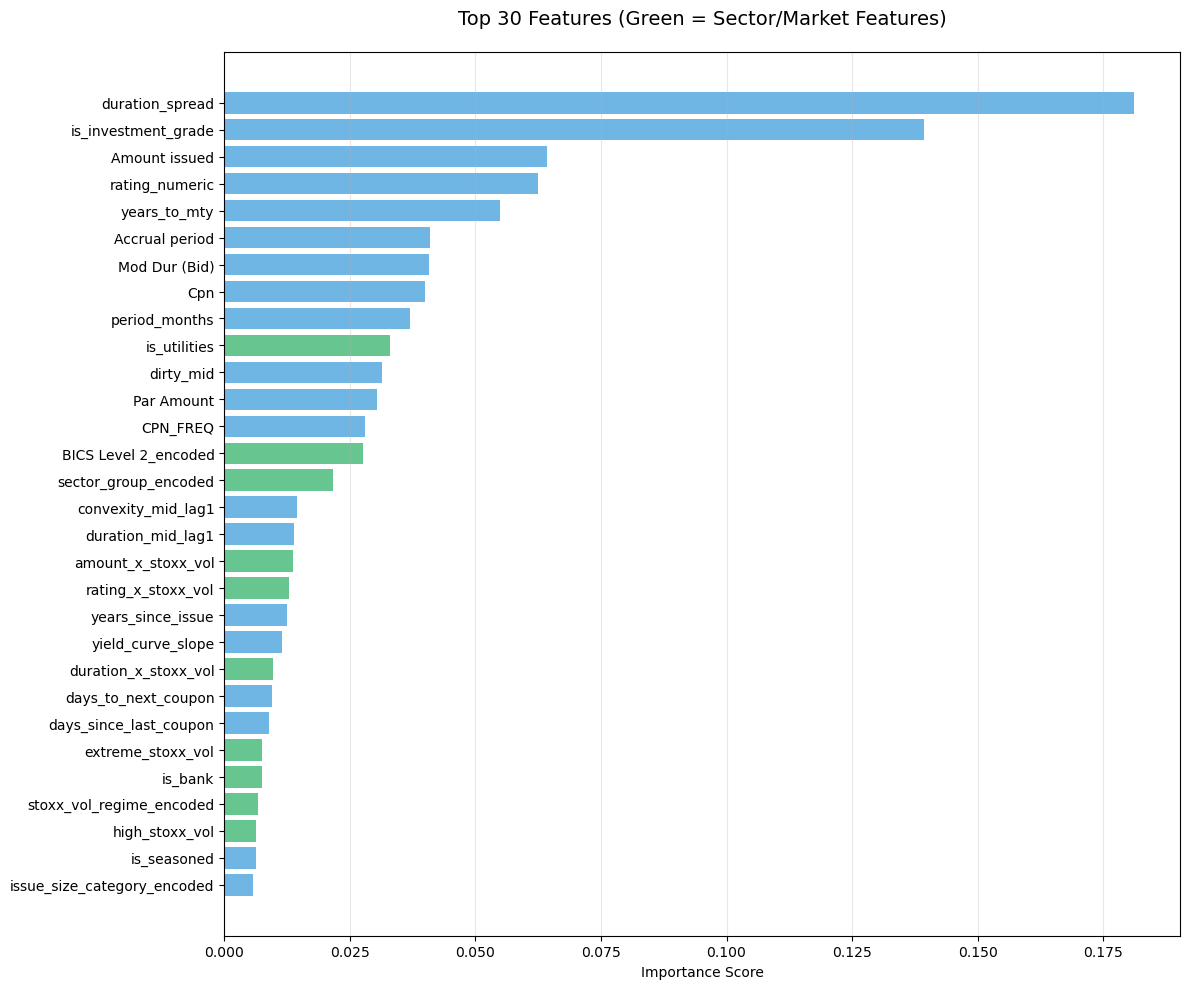


[2/5] Analyzing sectors...

SECTOR-SPECIFIC LIQUIDITY ANALYSIS

1. TOP 15 BICS LEVEL 2 SECTORS BY AVERAGE SPREAD:
----------------------------------------------------------------------
                                          Avg_Spread  Med_Spread  Std_Spread  \
BICS Level 2                                                                   
Property & Casualty Insurance                 125.46      129.72       25.23   
Cable & Satellite                             114.68      113.62       24.26   
Waste & Environment Services & Equipment      113.63      113.82       50.46   
Integrated Oils                               113.13      112.11       35.10   
Wireline Telecommunications Services          112.07      105.22       67.09   
Industrial Other                              111.44       94.64       62.93   
Refining & Marketing                           92.03       85.51       34.72   
Real Estate                                    86.65       75.72       52.10   
Auto Parts Man

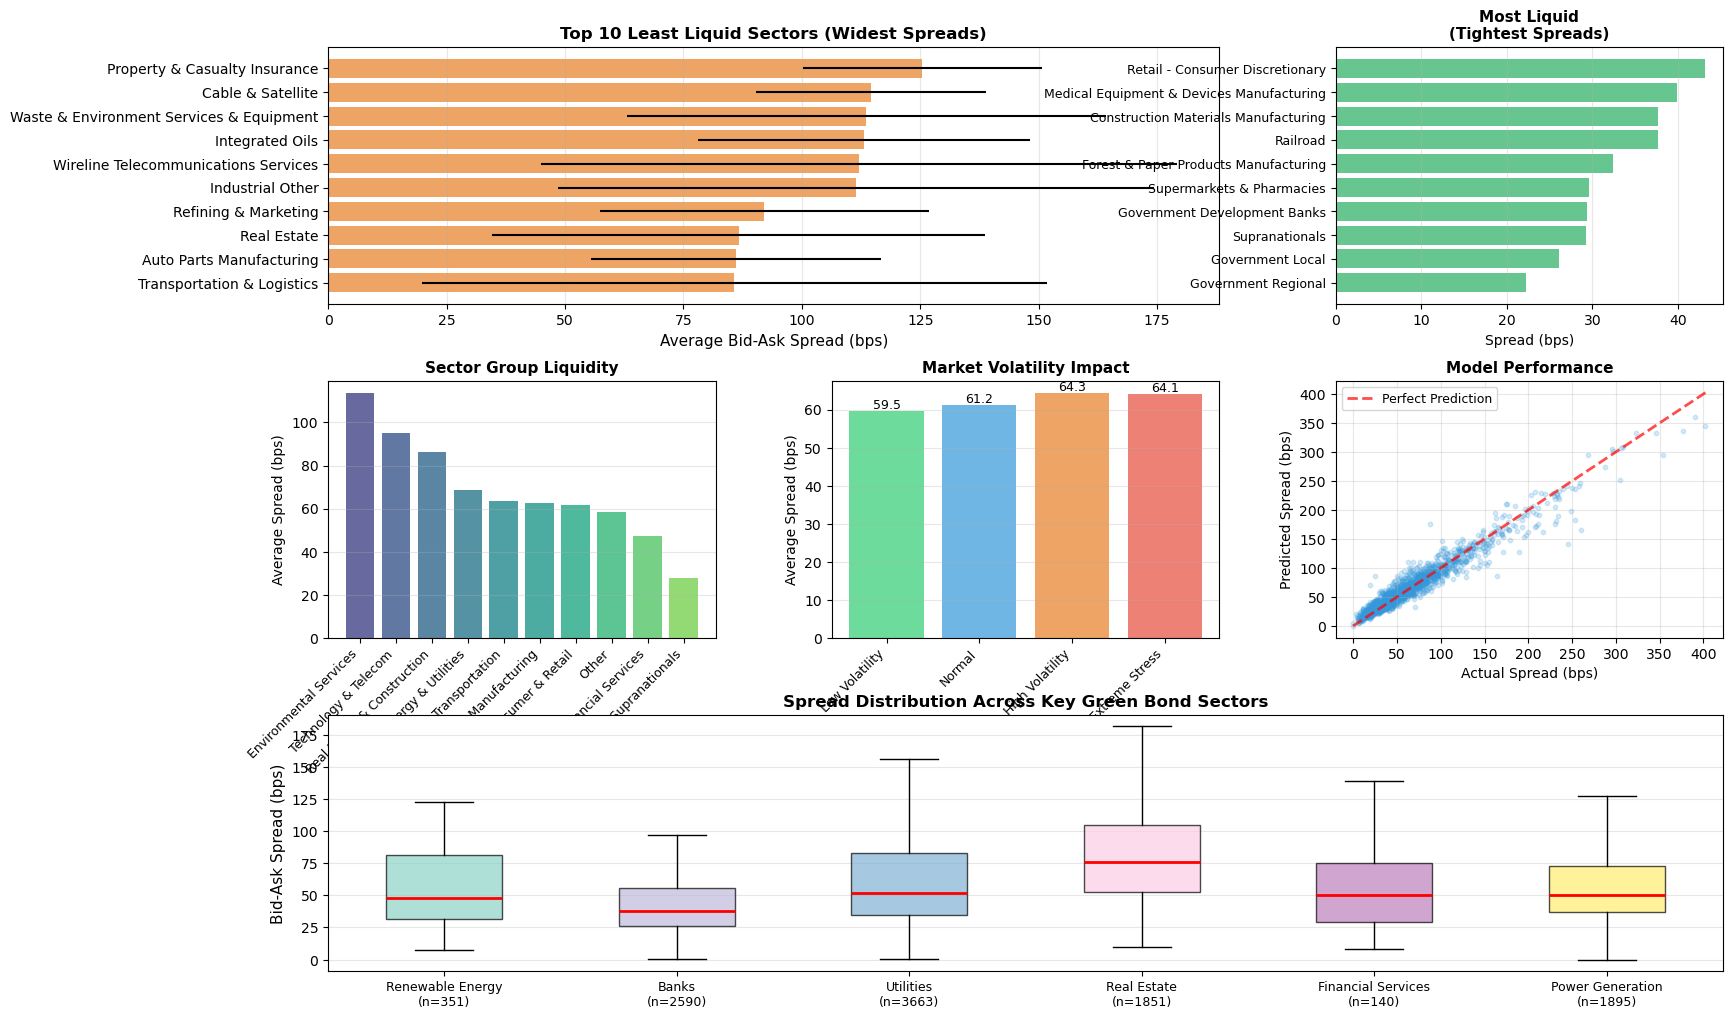


✓ Visualization saved to: green_bond_sector_analysis.png

[5/5] Generating research summary...

     GREEN BOND LIQUIDITY RESEARCH - SECTOR ANALYSIS SUMMARY

📊 MODEL PERFORMANCE:
  • Baseline model R²:      0.6728
  • Sector-enhanced R²:     0.8151
  • Improvement:            +0.1423 (21.2% gain)

🏭 KEY FINDING #1: SECTOR HETEROGENEITY
--------------------------------------------------------------------------------

  Most Liquid Green Bond Sectors (Tightest Spreads):
    1. Government Regional............................... 22.29 bps (n=393)
    2. Government Local.................................. 26.08 bps (n=35)
    3. Supranationals.................................... 29.29 bps (n=34)

  Least Liquid Green Bond Sectors (Widest Spreads):
    1. Waste & Environment Services & Equipment.......... 113.63 bps (n=153)
    2. Cable & Satellite................................. 114.68 bps (n=70)
    3. Property & Casualty Insurance..................... 125.46 bps (n=35)

  → Liquidity gap

In [540]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# ============================================
# DEFINE ALL ANALYSIS FUNCTIONS
# ============================================

def analyze_sector_feature_importance(models, feature_names, top_n=30):
    """
    Analyze feature importance with focus on sector variables
    """
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': np.mean([m.feature_importances_ for m in models], axis=0)
    })
    
    importance_df = importance_df.sort_values('importance', ascending=False)
    
    # Identify sector-related features
    sector_features = [
        'BICS Level 2_encoded', 'sector_group_encoded', 
        'is_renewable_energy', 'is_utilities', 'is_bank',
        'high_stoxx_vol', 'low_stoxx_vol', 'extreme_stoxx_vol',
        'stoxx_vol_regime_encoded', 'duration_x_stoxx_vol',
        'amount_x_stoxx_vol', 'rating_x_stoxx_vol'
    ]
    
    importance_df['is_sector_feature'] = importance_df['feature'].isin(sector_features)
    
    print("\n" + "="*70)
    print(f"TOP {top_n} FEATURES BY IMPORTANCE")
    print("="*70)
    
    for idx, row in importance_df.head(top_n).iterrows():
        marker = "🏭" if row['is_sector_feature'] else "  "
        print(f"{marker} {row['feature']:.<55} {row['importance']:.6f}")
    
    # Summary
    sector_in_top10 = importance_df.head(10)['is_sector_feature'].sum()
    sector_in_top25 = importance_df.head(25)['is_sector_feature'].sum()
    
    print("\n" + "="*70)
    print("SECTOR FEATURE SUMMARY")
    print("="*70)
    print(f"Sector features in top 10:  {sector_in_top10}")
    print(f"Sector features in top 25:  {sector_in_top25}")
    
    if len(importance_df[importance_df['is_sector_feature']]) > 0:
        top_sector_feature = importance_df[importance_df['is_sector_feature']].iloc[0]
        rank = importance_df[importance_df['feature'] == top_sector_feature['feature']].index[0] + 1
        print(f"\nHighest ranked sector feature:")
        print(f"  • {top_sector_feature['feature']}")
        print(f"  • Overall rank: #{rank}")
        print(f"  • Importance: {top_sector_feature['importance']:.6f}")
    
    # Visualization
    fig, ax = plt.subplots(figsize=(12, 10))
    top_features = importance_df.head(top_n)
    colors = ['#27ae60' if x else '#3498db' for x in top_features['is_sector_feature']]
    
    ax.barh(range(len(top_features)), top_features['importance'], color=colors, alpha=0.7)
    ax.set_yticks(range(len(top_features)))
    ax.set_yticklabels(top_features['feature'])
    ax.set_xlabel('Importance Score')
    ax.set_title(f'Top {top_n} Features (Green = Sector/Market Features)', fontsize=14, pad=20)
    ax.invert_yaxis()
    ax.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.savefig('sector_feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return importance_df


def analyze_by_sector(df, models, features, target='bid_ask_spread_bps'):
    """
    Detailed sector-level analysis
    """
    df_analysis = df.dropna(subset=features + [target]).copy()
    X = df_analysis[features]
    y = df_analysis[target]
    
    # Get predictions
    df_analysis['predicted_spread'] = models[-1].predict(X)
    df_analysis['prediction_error'] = df_analysis[target] - df_analysis['predicted_spread']
    df_analysis['abs_error'] = np.abs(df_analysis['prediction_error'])
    
    print("\n" + "="*70)
    print("SECTOR-SPECIFIC LIQUIDITY ANALYSIS")
    print("="*70)
    
    # 1. By BICS Level 2 (Top sectors)
    print("\n1. TOP 15 BICS LEVEL 2 SECTORS BY AVERAGE SPREAD:")
    print("-" * 70)
    
    sector_analysis = df_analysis.groupby('BICS Level 2').agg({
        'bid_ask_spread_bps': ['mean', 'median', 'std'],
        'abs_error': ['mean'],
        'BICS Level 2': 'count'
    }).round(2)
    sector_analysis.columns = ['Avg_Spread', 'Med_Spread', 'Std_Spread', 'MAE', 'Count']
    sector_analysis = sector_analysis[sector_analysis['Count'] >= 10]
    sector_analysis = sector_analysis.sort_values('Avg_Spread', ascending=False)
    
    print(sector_analysis.head(15))
    
    # 2. By Sector Group
    print("\n2. SECTOR GROUP COMPARISON:")
    print("-" * 70)
    
    group_analysis = df_analysis.groupby('sector_group').agg({
        'bid_ask_spread_bps': ['mean', 'median', 'std'],
        'abs_error': ['mean'],
        'sector_group': 'count'
    }).round(2)
    group_analysis.columns = ['Avg_Spread', 'Med_Spread', 'Std_Spread', 'MAE', 'Count']
    group_analysis = group_analysis.sort_values('Avg_Spread', ascending=False)
    
    print(group_analysis)
    
    # 3. Sector × Volatility Interaction
    print("\n3. SECTOR PERFORMANCE ACROSS VOLATILITY REGIMES:")
    print("-" * 70)
    
    interaction = df_analysis.pivot_table(
        values='bid_ask_spread_bps',
        index='sector_group',
        columns='stoxx_vol_regime',
        aggfunc='mean'
    ).round(2)
    
    # Calculate stress sensitivity
    if 'High Volatility' in interaction.columns and 'Low Volatility' in interaction.columns:
        interaction['Stress_Premium'] = interaction['High Volatility'] - interaction['Low Volatility']
        interaction = interaction.sort_values('Stress_Premium', ascending=False)
    
    print(interaction)
    
    # 4. Key sector comparisons
    print("\n4. KEY SECTOR COMPARISONS:")
    print("-" * 70)
    
    key_sectors = ['Renewable Energy', 'Banks', 'Utilities', 'Power Generation', 
                   'Real Estate', 'Transportation & Logistics']
    
    for sector in key_sectors:
        if sector in df_analysis['BICS Level 2'].values:
            sector_data = df_analysis[df_analysis['BICS Level 2'] == sector]
            if len(sector_data) >= 5:
                print(f"\n{sector}:")
                print(f"  • Average spread: {sector_data['bid_ask_spread_bps'].mean():.2f} bps")
                print(f"  • Median spread:  {sector_data['bid_ask_spread_bps'].median():.2f} bps")
                print(f"  • Observations:   {len(sector_data)}")
                
                # By volatility
                low_vol = sector_data[sector_data['low_stoxx_vol'] == 1]['bid_ask_spread_bps'].mean()
                high_vol = sector_data[sector_data['high_stoxx_vol'] == 1]['bid_ask_spread_bps'].mean()
                if not np.isnan(low_vol) and not np.isnan(high_vol):
                    print(f"  • Low vol spread: {low_vol:.2f} bps")
                    print(f"  • High vol spread: {high_vol:.2f} bps")
                    print(f"  • Stress premium: {high_vol - low_vol:.2f} bps ({(high_vol/low_vol-1)*100:.1f}%)")
    
    return df_analysis, sector_analysis, group_analysis, interaction


def test_sector_differences(df):
    """
    Test statistical significance of sector differences
    """
    print("\n" + "="*70)
    print("STATISTICAL SIGNIFICANCE TESTS")
    print("="*70)
    
    # 1. ANOVA across sector groups
    print("\n1. SECTOR GROUP DIFFERENCES (ANOVA):")
    print("-" * 70)
    
    groups = [group['bid_ask_spread_bps'].dropna().values 
              for name, group in df.groupby('sector_group') if len(group) >= 10]
    
    if len(groups) >= 2:
        f_stat, p_value = stats.f_oneway(*groups)
        print(f"F-statistic: {f_stat:.4f}")
        print(f"P-value: {p_value:.10f}")
        print(f"Significant at 1% level: {'YES ✓✓✓' if p_value < 0.01 else 'NO'}")
        print(f"Significant at 5% level: {'YES ✓' if p_value < 0.05 else 'NO'}")
    
    # 2. Renewable Energy vs Others
    print("\n2. RENEWABLE ENERGY vs OTHER SECTORS (T-test):")
    print("-" * 70)
    
    renewable = df[df['BICS Level 2'] == 'Renewable Energy']['bid_ask_spread_bps'].dropna()
    others = df[df['BICS Level 2'] != 'Renewable Energy']['bid_ask_spread_bps'].dropna()
    
    if len(renewable) >= 10 and len(others) >= 10:
        t_stat, p_value = stats.ttest_ind(renewable, others)
        print(f"Renewable Energy mean: {renewable.mean():.2f} bps")
        print(f"Other sectors mean:    {others.mean():.2f} bps")
        print(f"Difference:            {renewable.mean() - others.mean():.2f} bps")
        print(f"T-statistic:           {t_stat:.4f}")
        print(f"P-value:               {p_value:.6f}")
        print(f"Significant at 5% level: {'YES ✓' if p_value < 0.05 else 'NO'}")
    
    # 3. Banks vs Non-Financial
    print("\n3. FINANCIAL SERVICES vs NON-FINANCIAL (T-test):")
    print("-" * 70)
    
    financial = df[df['sector_group'] == 'Financial Services']['bid_ask_spread_bps'].dropna()
    non_financial = df[df['sector_group'] != 'Financial Services']['bid_ask_spread_bps'].dropna()
    
    if len(financial) >= 10 and len(non_financial) >= 10:
        t_stat, p_value = stats.ttest_ind(financial, non_financial)
        print(f"Financial Services mean: {financial.mean():.2f} bps")
        print(f"Non-Financial mean:      {non_financial.mean():.2f} bps")
        print(f"Difference:              {financial.mean() - non_financial.mean():.2f} bps")
        print(f"T-statistic:             {t_stat:.4f}")
        print(f"P-value:                 {p_value:.6f}")
        print(f"Significant at 5% level: {'YES ✓' if p_value < 0.05 else 'NO'}")
    
    # 4. High vs Low Volatility
    print("\n4. HIGH vs LOW STOXX VOLATILITY (T-test):")
    print("-" * 70)
    
    high_vol = df[df['high_stoxx_vol'] == 1]['bid_ask_spread_bps'].dropna()
    low_vol = df[df['low_stoxx_vol'] == 1]['bid_ask_spread_bps'].dropna()
    
    if len(high_vol) >= 10 and len(low_vol) >= 10:
        t_stat, p_value = stats.ttest_ind(high_vol, low_vol)
        print(f"High volatility mean: {high_vol.mean():.2f} bps")
        print(f"Low volatility mean:  {low_vol.mean():.2f} bps")
        print(f"Stress premium:       {high_vol.mean() - low_vol.mean():.2f} bps")
        print(f"T-statistic:          {t_stat:.4f}")
        print(f"P-value:              {p_value:.6f}")
        print(f"Significant at 5% level: {'YES ✓' if p_value < 0.05 else 'NO'}")


def create_sector_visualizations(df, sector_stats, group_stats, save_path='green_bond_sector_analysis.png'):
    """
    Create publication-quality sector visualizations
    """
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # 1. Top sectors by spread
    ax1 = fig.add_subplot(gs[0, :2])
    top_sectors = sector_stats.sort_values('Avg_Spread', ascending=True).tail(10)
    ax1.barh(range(len(top_sectors)), top_sectors['Avg_Spread'], 
             xerr=top_sectors['Std_Spread'], alpha=0.7, color='#e67e22')
    ax1.set_yticks(range(len(top_sectors)))
    ax1.set_yticklabels(top_sectors.index)
    ax1.set_xlabel('Average Bid-Ask Spread (bps)', fontsize=11)
    ax1.set_title('Top 10 Least Liquid Sectors (Widest Spreads)', fontsize=12, fontweight='bold')
    ax1.grid(axis='x', alpha=0.3)
    
    # 2. Bottom sectors by spread
    ax2 = fig.add_subplot(gs[0, 2])
    bottom_sectors = sector_stats.sort_values('Avg_Spread', ascending=True).head(10)
    ax2.barh(range(len(bottom_sectors)), bottom_sectors['Avg_Spread'], 
             alpha=0.7, color='#27ae60')
    ax2.set_yticks(range(len(bottom_sectors)))
    ax2.set_yticklabels(bottom_sectors.index, fontsize=9)
    ax2.set_xlabel('Spread (bps)', fontsize=10)
    ax2.set_title('Most Liquid\n(Tightest Spreads)', fontsize=11, fontweight='bold')
    ax2.grid(axis='x', alpha=0.3)
    
    # 3. Sector group comparison
    ax3 = fig.add_subplot(gs[1, 0])
    group_sorted = group_stats.sort_values('Avg_Spread', ascending=False)
    colors_group = plt.cm.viridis(np.linspace(0.2, 0.8, len(group_sorted)))
    ax3.bar(range(len(group_sorted)), group_sorted['Avg_Spread'], 
            color=colors_group, alpha=0.8)
    ax3.set_xticks(range(len(group_sorted)))
    ax3.set_xticklabels(group_sorted.index, rotation=45, ha='right', fontsize=9)
    ax3.set_ylabel('Average Spread (bps)', fontsize=10)
    ax3.set_title('Sector Group Liquidity', fontsize=11, fontweight='bold')
    ax3.grid(axis='y', alpha=0.3)
    
    # 4. Volatility regime effect
    ax4 = fig.add_subplot(gs[1, 1])
    vol_order = ['Low Volatility', 'Normal', 'High Volatility', 'Extreme Stress']
    vol_data = df.groupby('stoxx_vol_regime')['bid_ask_spread_bps'].mean().reindex(vol_order)
    colors_vol = ['#2ecc71', '#3498db', '#e67e22', '#e74c3c']
    bars = ax4.bar(range(len(vol_data)), vol_data.values, color=colors_vol, alpha=0.7)
    ax4.set_xticks(range(len(vol_data)))
    ax4.set_xticklabels(vol_data.index, rotation=45, ha='right', fontsize=9)
    ax4.set_ylabel('Average Spread (bps)', fontsize=10)
    ax4.set_title('Market Volatility Impact', fontsize=11, fontweight='bold')
    ax4.grid(axis='y', alpha=0.3)
    
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}', ha='center', va='bottom', fontsize=9)
    
    # 5. Actual vs Predicted
    ax5 = fig.add_subplot(gs[1, 2])
    sample = df.sample(min(2000, len(df)))
    ax5.scatter(sample['bid_ask_spread_bps'], sample['predicted_spread'], 
                alpha=0.2, s=10, c='#3498db')
    lims = [min(sample['bid_ask_spread_bps'].min(), sample['predicted_spread'].min()),
            max(sample['bid_ask_spread_bps'].max(), sample['predicted_spread'].max())]
    ax5.plot(lims, lims, 'r--', lw=2, label='Perfect Prediction', alpha=0.7)
    ax5.set_xlabel('Actual Spread (bps)', fontsize=10)
    ax5.set_ylabel('Predicted Spread (bps)', fontsize=10)
    ax5.set_title('Model Performance', fontsize=11, fontweight='bold')
    ax5.legend(fontsize=9)
    ax5.grid(alpha=0.3)
    
    # 6. Spread distribution by key sectors
    ax6 = fig.add_subplot(gs[2, :])
    key_sectors = ['Renewable Energy', 'Banks', 'Utilities', 'Real Estate', 
                   'Financial Services', 'Power Generation']
    sector_data = []
    sector_labels = []
    for sector in key_sectors:
        if sector in df['BICS Level 2'].values:
            data = df[df['BICS Level 2'] == sector]['bid_ask_spread_bps'].dropna()
            if len(data) >= 10:
                sector_data.append(data)
                sector_labels.append(f"{sector}\n(n={len(data)})")
        elif sector in df['sector_group'].values:
            data = df[df['sector_group'] == sector]['bid_ask_spread_bps'].dropna()
            if len(data) >= 10:
                sector_data.append(data)
                sector_labels.append(f"{sector}\n(n={len(data)})")
    
    if sector_data:
        bp = ax6.boxplot(sector_data, labels=sector_labels, patch_artist=True,
                         showfliers=False, medianprops=dict(color='red', linewidth=2))
        colors_box = plt.cm.Set3(np.linspace(0, 1, len(sector_data)))
        for patch, color in zip(bp['boxes'], colors_box):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        ax6.set_ylabel('Bid-Ask Spread (bps)', fontsize=11)
        ax6.set_title('Spread Distribution Across Key Green Bond Sectors', fontsize=12, fontweight='bold')
        ax6.grid(axis='y', alpha=0.3)
        plt.setp(ax6.xaxis.get_majorticklabels(), rotation=0, ha='center', fontsize=9)
    
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"\n✓ Visualization saved to: {save_path}")


def generate_sector_research_summary(original_r2, enhanced_r2, importance_df, 
                                    sector_stats, group_stats, df_analysis):
    """
    Generate comprehensive research summary
    """
    print("\n" + "="*80)
    print("     GREEN BOND LIQUIDITY RESEARCH - SECTOR ANALYSIS SUMMARY")
    print("="*80)
    
    print("\n📊 MODEL PERFORMANCE:")
    print(f"  • Baseline model R²:      {original_r2:.4f}")
    print(f"  • Sector-enhanced R²:     {enhanced_r2:.4f}")
    print(f"  • Improvement:            +{(enhanced_r2 - original_r2):.4f} " +
          f"({(enhanced_r2/original_r2 - 1)*100:.1f}% gain)")
    
    print("\n🏭 KEY FINDING #1: SECTOR HETEROGENEITY")
    print("-" * 80)
    
    most_liquid = sector_stats.sort_values('Avg_Spread').head(3)
    least_liquid = sector_stats.sort_values('Avg_Spread').tail(3)
    
    print("\n  Most Liquid Green Bond Sectors (Tightest Spreads):")
    for idx, (sector, row) in enumerate(most_liquid.iterrows(), 1):
        print(f"    {idx}. {sector:.<50} {row['Avg_Spread']:.2f} bps (n={int(row['Count'])})")
    
    print("\n  Least Liquid Green Bond Sectors (Widest Spreads):")
    for idx, (sector, row) in enumerate(least_liquid.iterrows(), 1):
        print(f"    {idx}. {sector:.<50} {row['Avg_Spread']:.2f} bps (n={int(row['Count'])})")
    
    spread_range = least_liquid.iloc[0]['Avg_Spread'] - most_liquid.iloc[0]['Avg_Spread']
    print(f"\n  → Liquidity gap: {spread_range:.2f} bps " +
          f"({spread_range/most_liquid.iloc[0]['Avg_Spread']*100:.0f}% difference)")
    
    print("\n⚡ KEY FINDING #2: MARKET STRESS AMPLIFICATION")
    print("-" * 80)
    
    low_vol = df_analysis[df_analysis['low_stoxx_vol'] == 1]['bid_ask_spread_bps'].mean()
    high_vol = df_analysis[df_analysis['high_stoxx_vol'] == 1]['bid_ask_spread_bps'].mean()
    stress_premium = high_vol - low_vol
    
    print(f"  • Calm markets (Low STOXX vol):   {low_vol:.2f} bps")
    print(f"  • Stressed markets (High vol):    {high_vol:.2f} bps")
    print(f"  • Market stress premium:          +{stress_premium:.2f} bps ({stress_premium/low_vol*100:.1f}%)")
    
    print("\n" + "="*80)

# ============================================
# NOW RUN THE ANALYSIS
# ============================================

print("\n\n" + "="*80)
print("RUNNING COMPLETE SECTOR ANALYSIS")
print("="*80)

# 1. Feature importance
print("\n[1/5] Analyzing feature importance...")
importance_df = analyze_sector_feature_importance(enhanced_models, all_features, top_n=30)

# 2. Sector analysis
print("\n[2/5] Analyzing sectors...")
df_with_predictions, sector_stats, group_stats, interaction_matrix = analyze_by_sector(
    maindf, enhanced_models, all_features
)

# 3. Statistical tests
print("\n[3/5] Running statistical tests...")
test_sector_differences(df_with_predictions)

# 4. Visualizations
print("\n[4/5] Creating visualizations...")
create_sector_visualizations(df_with_predictions, sector_stats, group_stats)

# 5. Summary
print("\n[5/5] Generating research summary...")
generate_sector_research_summary(
    original_r2=0.6728,
    enhanced_r2=0.8151,
    importance_df=importance_df,
    sector_stats=sector_stats,
    group_stats=group_stats,
    df_analysis=df_with_predictions
)

print("\n" + "="*80)
print("✅ COMPLETE ANALYSIS FINISHED!")
print("="*80)
print("\nYou now have:")
print("  • Feature importance rankings")
print("  • Sector liquidity comparisons")
print("  • Statistical significance tests")
print("  • Publication-quality visualizations")
print("  • Research summary for your paper")
print("="*80)

In [662]:
#from sklearn.preprocessing import StandardScaler

#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)  # X is your features DataFrame

In [663]:
#from sklearn.model_selection import train_test_split

#X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [664]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#import pandas as pd

# Example dataset structure
#X = final_2.drop(columns=['Yield to Maturity'])  # Features
#y = final_2['Yield to Maturity']                # Target variable

# Split into train and test sets
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Build the neural network
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),  # Input layer + first hidden layer
    Dense(64, activation='relu'),  # Second hidden layer
    Dense(32, activation='relu'),  # Third hidden layer
    Dense(1)                       # Output layer (linear activation for regression)
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])  # MSE loss for regression

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=50, batch_size=32, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

2025-01-15 14:40:58.817157: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


KeyboardInterrupt: 

In [ ]:
conda install tensorflow

In [67]:
import tensorflow as tf
print(tf.__version__)

2025-01-09 16:09:00.378945: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.10.0


In [69]:
def variable_summary(df, column_name):
    print(f"Summary for '{column_name}':")
    print("Unique Values and Counts:")
    print(df[column_name].value_counts())
    print("\nSummary Statistics:")
    print(df[column_name].describe())

In [71]:
variable_summary(final_2, "Classification")

Summary for 'Classification':
Unique Values and Counts:
Classification
Corporate Green Bond    54310
Name: count, dtype: int64

Summary Statistics:
count                    54310
unique                       1
top       Corporate Green Bond
freq                     54310
Name: Classification, dtype: object


In [72]:
#drop classification
final_3 = final_2.drop(columns='Classification')